# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [1]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=33bab6df95b2f966dc9077f26ed32592cf69093c5ae321ba9f26606e745770ce
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
!signate files --competition-id=1523


Could not find /root/.signate/signate.json.
Please get the API token from this page: https://signate.jp/account_settings



In [3]:
!signate download --competition-id=1523


Could not find /root/.signate/signate.json.
Please get the API token from this page: https://signate.jp/account_settings



In [4]:
!pip install kanjize

In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.0 MB/s eta 0:00:00


In [6]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/train.csv'

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [ ]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-33-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

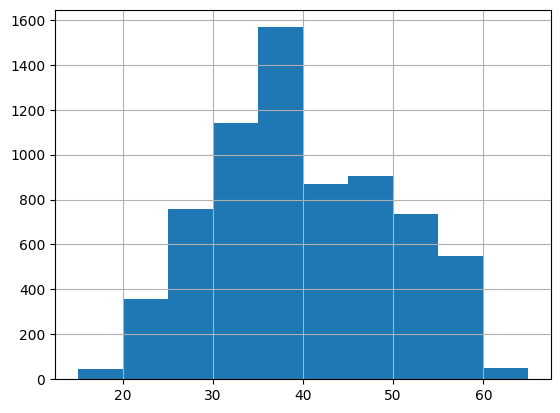

In [ ]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [ ]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

all_df["CompanyInvited"] = all_df["CompanyInvited"].astype(int)
print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [ ]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [ ]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [ ]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [ ]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

all_df["Male"] = all_df["Male"].astype(int)
print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [ ]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

all_df["ProductPitched"] = all_df["ProductPitched"].astype(int)

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [ ]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [ ]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [ ]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [ ]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [ ]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()
all_df["Designation"] = all_df["Designation"].astype(int)

<Axes: >

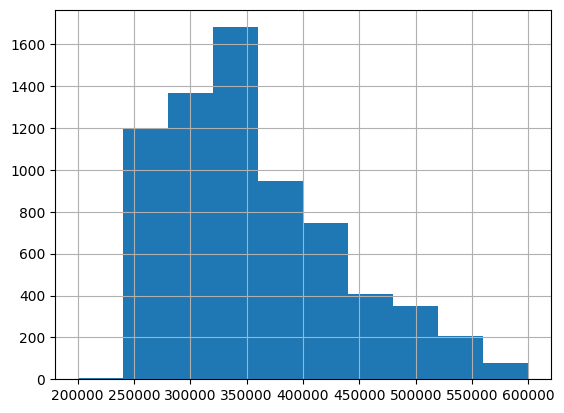

In [ ]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [ ]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [ ]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [ ]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [ ]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [ ]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [ ]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

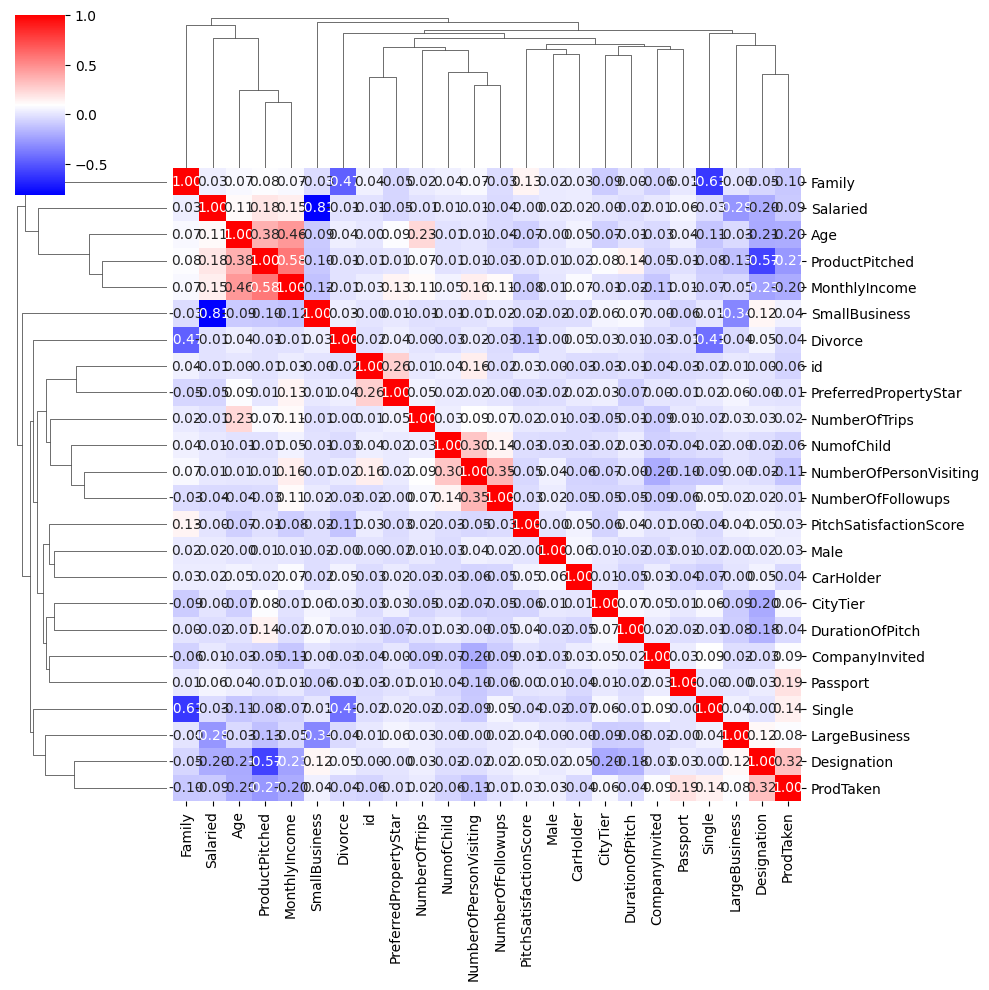

In [ ]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [ ]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

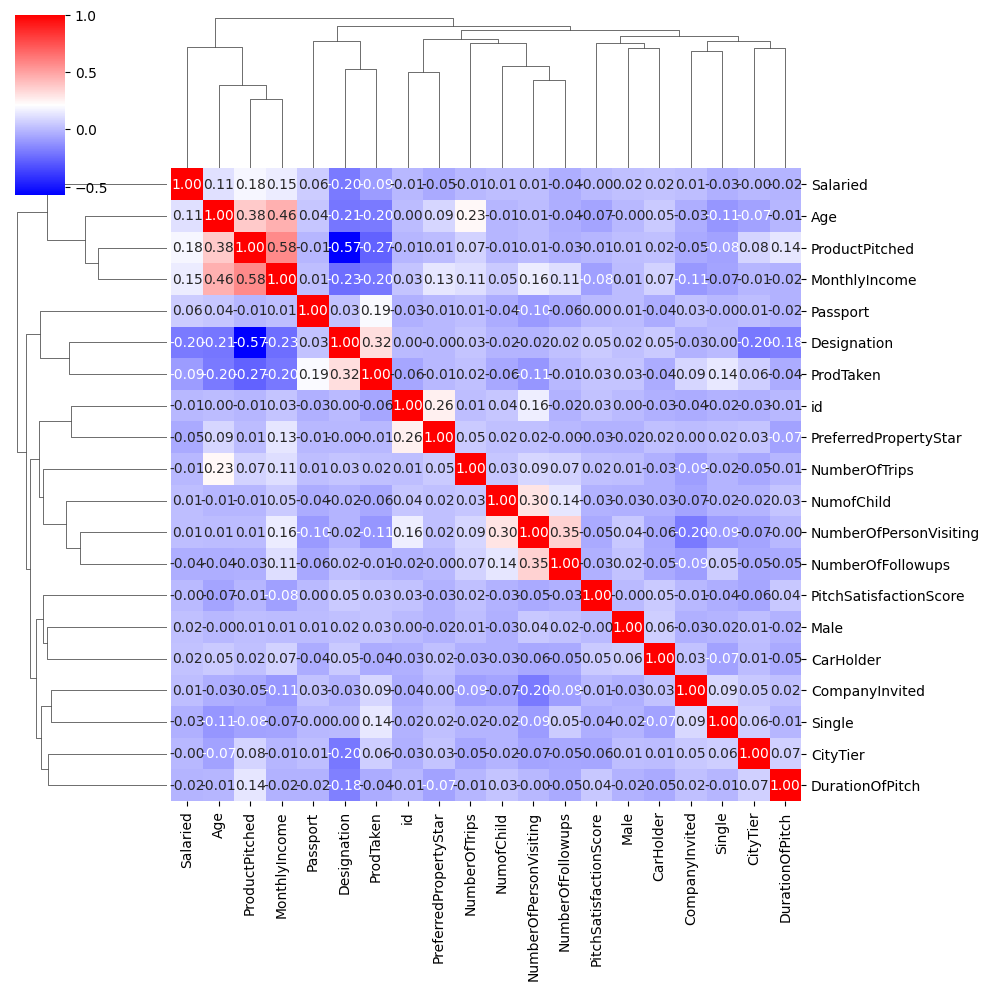

In [ ]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [ ]:
plus = all_df[all_df["ProdTaken"]==1] # 正例
minus = all_df[all_df["ProdTaken"]==0]  # 負例
train = pd.concat([plus,minus])
# 全体数の比
print("正例：", len(plus))
print("負例：", len(minus))
print("比率：", len(minus)/len(plus))

正例： 497
負例： 2992
比率： 6.020120724346077


In [ ]:
train.groupby("ProdTaken").mean()

,id,Age,CompanyInvited,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single
ProdTaken,,,,,,,,,,,,,,,,,,,
0.0,1769.117313,40.188503,0.352273,1.680816,0.953209,0.420455,0.141711,2.428142,3.674465,2.382687,1.442513,1.414773,0.078543,2.500000,2.629011,361609.074198,0.384693,0.384358,0.323529
1.0,1592.790744,34.625755,0.472837,1.794769,0.863179,0.287726,0.17505,2.193159,3.657948,1.519115,1.432596,1.454728,0.247485,2.597586,4.136821,318393.682093,0.323944,0.279678,0.521127


In [ ]:
# パスポート所持率が高い
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)
data1 = train.loc[train["ProdTaken"]==1].mean()
data0 = train.loc[train["ProdTaken"]==0].mean()
data0 = data0.drop("ProdTaken", axis=0)
data1 = data1.drop("ProdTaken", axis=0)
print(data1/data0)

id                        0.900331
Age                       0.861584
CompanyInvited            1.342247
CityTier                  1.067796
DurationOfPitch           0.905551
Salaried                  0.684322
Male                      1.235261
NumberOfPersonVisiting    0.903225
NumberOfFollowups         0.995505
ProductPitched            0.637564
PreferredPropertyStar     0.993125
NumberOfTrips             1.028242
Passport                  3.150957
PitchSatisfactionScore    1.039034
Designation               1.573528
MonthlyIncome             0.880491
CarHolder                 0.842085
NumofChild                0.727649
Single                    1.610755
dtype: object


# 学習準備

In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# まずはseed複数のスコア平均を取る環境を作ること

In [ ]:
# # クロス特徴量の追加
# # 「パスポート」x「独身」
# all_df["Passport_Single"] = all_df["Passport"] | all_df["Single"]

# # 「パスポート」x「役職」
# all_df["Passport_Designation"] = all_df["Passport"] & all_df["Designation"]

# # 「会社招待」x「独身」
# all_df["CompanyInvited_Single"] = all_df["CompanyInvited"] & all_df["Single"]


In [ ]:
# # 相関係数の確認OK
# all_df_corr = all_df.corr()
# sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
# plt.show()

In [ ]:
# 古い列を削除
# all_df = all_df.drop("Salaried", axis=1)

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# 順番を整列させる
col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

# ここから学習作業

In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [ ]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [ ]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),

    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

  # 複数シードの平均を取る
  seed = [0, 42, 2025]
  FOLDS = 5 # 分割数
  oof_score = np.zeros(len(seed))

  # SEEDごとのスコアを出す
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # 各FOLDのスコアを出す
    for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

      print("#"*25)
      print(f"### Fold {i+1}")
      print("#"*25)

      # インデックスに割り振る
      x_train = train.loc[train_index, FEATURES].copy()
      y_train = train.loc[train_index, TARGET]
      x_valid = train.loc[test_index, FEATURES].copy()
      y_valid = train.loc[test_index, TARGET]

      # データセット作成
      lgb_train = lgb.Dataset(x_train, y_train)
      lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

      # 学習
      model_lgb = lgb.train(lgbm_params,
                            lgb_train,
                            num_boost_round = 2000,
                            valid_sets = [lgb_train, lgb_eval],
                            valid_names = ["train", "valid"],
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=100, verbose=False),
                                lgb.log_evaluation(100),])

      # valid予測
      oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    # AUCの算出
    oof_score[j] = roc_auc_score(train[TARGET],oof_lgb)

  score = np.mean(oof_score)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-28 13:30:10,589] A new study created in memory with name: no-name-51a31df8-5283-4574-9b7c-9df095500452
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833441	valid's auc: 0.843754
#########################
### Fold 2
#########################
[100]	train's auc: 0.844931	valid's auc: 0.812191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852565	valid's auc: 0.817316
[300]	train's auc: 0.862849	valid's auc: 0.819983
[400]	train's auc: 0.871515	valid's auc: 0.81893
#########################
### Fold 3
#########################
[100]	train's auc: 0.843497	valid's auc: 0.799784


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855264	valid's auc: 0.80454
[300]	train's auc: 0.862053	valid's auc: 0.809598
[400]	train's auc: 0.868647	valid's auc: 0.813241
[500]	train's auc: 0.874413	valid's auc: 0.815484
#########################
### Fold 4
#########################
[100]	train's auc: 0.838433	valid's auc: 0.821858


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848344	valid's auc: 0.829109
[300]	train's auc: 0.858019	valid's auc: 0.833865
[400]	train's auc: 0.865991	valid's auc: 0.838485
[500]	train's auc: 0.871355	valid's auc: 0.84002
[600]	train's auc: 0.877166	valid's auc: 0.839986
[700]	train's auc: 0.881847	valid's auc: 0.840154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846342	valid's auc: 0.802042
[200]	train's auc: 0.858816	valid's auc: 0.809128
[300]	train's auc: 0.866124	valid's auc: 0.808284
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840139	valid's auc: 0.833018
[200]	train's auc: 0.849645	valid's auc: 0.837224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.837709	valid's auc: 0.822818


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846541	valid's auc: 0.829749
[300]	train's auc: 0.85675	valid's auc: 0.836773
[400]	train's auc: 0.86439	valid's auc: 0.839967
[500]	train's auc: 0.871589	valid's auc: 0.840452
[600]	train's auc: 0.876808	valid's auc: 0.840351
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845486	valid's auc: 0.791766
[200]	train's auc: 0.856032	valid's auc: 0.799008
[300]	train's auc: 0.865495	valid's auc: 0.80432
[400]	train's auc: 0.872062	valid's auc: 0.806513
[500]	train's auc: 0.878794	valid's auc: 0.806563
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841504	valid's auc: 0.829143
[200]	train's auc: 0.851541	valid's auc: 0.830644
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844383	valid's auc: 0.802135
[200]	train's auc: 0.855463	valid's auc: 0.810699
[300]	train's auc: 0.864323	valid's auc: 0.816983
[400]	train's auc: 0.871703	valid's auc: 0.816966
[500]	train's auc: 0.877229	valid's auc: 0.817506
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84165	valid's auc: 0.808018
[200]	train's auc: 0.851502	valid's auc: 0.816923
[300]	train's auc: 0.861263	valid's auc: 0.821605
[400]	train's auc: 0.868422	valid's auc: 0.824264
[500]	train's auc: 0.874242	valid's auc: 0.826338
[600]	train's auc: 0.879276	valid's auc: 0.828127
[700]	train's auc: 0.883918	valid's auc: 0.828478
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83279	valid's auc: 0.854013
[200]	train's auc: 0.845524	valid's auc: 0.859406
[300]	train's auc: 0.853645	valid's auc: 0.860585
#########################
### Fold 3
#########################
[100]	train's auc: 0.845244	valid's auc: 0.80416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85503	valid's auc: 0.811723
[300]	train's auc: 0.863257	valid's auc: 0.814286
[400]	train's auc: 0.869649	valid's auc: 0.815028
[500]	train's auc: 0.876578	valid's auc: 0.815703
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84305	valid's auc: 0.776606
[200]	train's auc: 0.858093	valid's auc: 0.786251
[300]	train's auc: 0.868195	valid's auc: 0.793444
[400]	train's auc: 0.876395	valid's auc: 0.796968
[500]	train's auc: 0.882999	valid's auc: 0.797946
#########################
### Fold 5
#########################
[100]	train's auc: 0.83977	valid's auc: 0.824786


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851082	valid's auc: 0.827894
[300]	train's auc: 0.859419	valid's auc: 0.83009


[I 2025-05-28 13:30:21,601] Trial 0 finished with value: 0.8159646380959554 and parameters: {'feature_fraction': 0.7963631752064582, 'num_leaves': 21, 'bagging_fraction': 0.6522863110558415, 'bagging_freq': 5, 'lambda_l1': 3.4391603635009975, 'lambda_l2': 0.12891257110258028, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.8159646380959554.


[400]	train's auc: 0.868448	valid's auc: 0.827877
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.831129	valid's auc: 0.843921
#########################
### Fold 2
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842541	valid's auc: 0.81036
[200]	train's auc: 0.852237	valid's auc: 0.818829
[300]	train's auc: 0.858233	valid's auc: 0.821338
[400]	train's auc: 0.863256	valid's auc: 0.823244
[500]	train's auc: 0.866661	valid's auc: 0.823846
[600]	train's auc: 0.869367	valid's auc: 0.823913
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846126	valid's auc: 0.791125
[200]	train's auc: 0.854148	valid's auc: 0.798123
[300]	train's auc: 0.858837	valid's auc: 0.801707
[400]	train's auc: 0.862728	valid's auc: 0.80513
[500]	train's auc: 0.865836	valid's auc: 0.807373
[600]	train's auc: 0.868258	valid's auc: 0.808401
[700]	train's auc: 0.870159	valid's auc: 0.809143
[800]	train's auc: 0.871631	valid's auc: 0.809548
[900]	train's auc: 0.872898	valid's auc: 0.809683
[1000]	train's auc: 0.873739	valid's auc: 0.81061
[1100]	train's auc: 0.874405	valid's auc: 0.810813
[1200]	train's auc: 0.87514	valid's auc: 0.810863
#########################
### Fold 4
#########################
[100]	train's auc: 0.836231	valid's auc: 0.81486


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84602	valid's auc: 0.825231
[300]	train's auc: 0.851932	valid's auc: 0.831065
[400]	train's auc: 0.856745	valid's auc: 0.835365
[500]	train's auc: 0.860378	valid's auc: 0.836698
[600]	train's auc: 0.863063	valid's auc: 0.837541
[700]	train's auc: 0.865086	valid's auc: 0.83808
[800]	train's auc: 0.866675	valid's auc: 0.838923
[900]	train's auc: 0.868218	valid's auc: 0.839918
[1000]	train's auc: 0.869309	valid's auc: 0.840509
[1100]	train's auc: 0.870052	valid's auc: 0.840981
[1200]	train's auc: 0.870711	valid's auc: 0.8412
[1300]	train's auc: 0.87129	valid's auc: 0.841402
#########################
### Fold 5
#########################
[100]	train's auc: 0.845578	valid's auc: 0.812701
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84007	valid's auc: 0.833311
#########################
### Fold 2
#########################
[100]	train's auc: 0.836781	valid's auc: 0.820702


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843725	valid's auc: 0.827876
[300]	train's auc: 0.85067	valid's auc: 0.835284
[400]	train's auc: 0.855152	valid's auc: 0.83903
[500]	train's auc: 0.85852	valid's auc: 0.841605
[600]	train's auc: 0.861348	valid's auc: 0.843144
[700]	train's auc: 0.863561	valid's auc: 0.843445
[800]	train's auc: 0.865394	valid's auc: 0.843662
[900]	train's auc: 0.867006	valid's auc: 0.843946
[1000]	train's auc: 0.8681	valid's auc: 0.844314
[1100]	train's auc: 0.868977	valid's auc: 0.844264
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846166	valid's auc: 0.795627
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842682	valid's auc: 0.827735
[200]	train's auc: 0.851506	valid's auc: 0.829935
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841385	valid's auc: 0.797482
[200]	train's auc: 0.849504	valid's auc: 0.804128
[300]	train's auc: 0.856036	valid's auc: 0.809635
[400]	train's auc: 0.861003	valid's auc: 0.813638
[500]	train's auc: 0.864466	valid's auc: 0.817202
[600]	train's auc: 0.866785	valid's auc: 0.819449
[700]	train's auc: 0.868722	valid's auc: 0.820716
[800]	train's auc: 0.870115	valid's auc: 0.82156
[900]	train's auc: 0.871292	valid's auc: 0.822878
[1000]	train's auc: 0.871865	valid's auc: 0.823452
[1100]	train's auc: 0.872558	valid's auc: 0.823874
[1200]	train's auc: 0.873101	valid's auc: 0.82455
[1300]	train's auc: 0.873738	valid's auc: 0.824837
[1400]	train's auc: 0.87437	valid's auc: 0.824955
[1500]	train's auc: 0.874831	valid's auc: 0.825141
[1600]	train's auc: 0.875146	valid's auc: 0.825462
[1700]	train's auc: 0.875407	valid's auc: 0.825378
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842105	valid's auc: 0.812625
#########################
### Fold 2
#########################
[100]	train's auc: 0.834733	valid's auc: 0.856865
[200]	train's auc: 0.844459	valid's auc: 0.862985
[300]	train's auc: 0.849114	valid's auc: 0.864097
#########################
### Fold 3
#########################
[100]	train's auc: 0.841274	valid's auc: 0.803258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852786	valid's auc: 0.813224
[300]	train's auc: 0.858305	valid's auc: 0.81314
[400]	train's auc: 0.862123	valid's auc: 0.816462
[500]	train's auc: 0.865942	valid's auc: 0.819177
[600]	train's auc: 0.868343	valid's auc: 0.82061
[700]	train's auc: 0.870318	valid's auc: 0.82115
[800]	train's auc: 0.871828	valid's auc: 0.822077
[900]	train's auc: 0.872927	valid's auc: 0.822667
[1000]	train's auc: 0.873969	valid's auc: 0.82287
[1100]	train's auc: 0.874663	valid's auc: 0.822903
[1200]	train's auc: 0.875266	valid's auc: 0.823072
[1300]	train's auc: 0.876034	valid's auc: 0.823258
[1400]	train's auc: 0.876534	valid's auc: 0.823005
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843304	valid's auc: 0.776682
#########################
### Fold 5
#########################
[100]	train's auc: 0.843455	valid's auc: 0.817118


[I 2025-05-28 13:30:34,696] Trial 1 finished with value: 0.801301682644889 and parameters: {'feature_fraction': 0.5388699819253195, 'num_leaves': 50, 'bagging_fraction': 0.8958496999299499, 'bagging_freq': 1, 'lambda_l1': 8.38189619601755, 'lambda_l2': 2.2798632619456018e-06, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.8159646380959554.


[200]	train's auc: 0.851609	valid's auc: 0.827827
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.823309	valid's auc: 0.840761
[200]	train's auc: 0.837541	valid's auc: 0.847341
[300]	train's auc: 0.845413	valid's auc: 0.853378
[400]	train's auc: 0.852242	valid's auc: 0.855903
[500]	train's auc: 0.856513	valid's auc: 0.85714
[600]	train's auc: 0.859035	valid's auc: 0.858528
[700]	train's auc: 0.861193	valid's auc: 0.858813
[800]	train's auc: 0.863376	valid's auc: 0.858913
#########################
### Fold 2
#########################
[100]	train's auc: 0.835434	valid's auc: 0.807467


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845894	valid's auc: 0.816689
[300]	train's auc: 0.852488	valid's auc: 0.820535
[400]	train's auc: 0.857177	valid's auc: 0.822291
[500]	train's auc: 0.861807	valid's auc: 0.823696
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834349	valid's auc: 0.787364
[200]	train's auc: 0.847163	valid's auc: 0.799767
[300]	train's auc: 0.853081	valid's auc: 0.802263
[400]	train's auc: 0.857413	valid's auc: 0.806597
[500]	train's auc: 0.860152	valid's auc: 0.8097
[600]	train's auc: 0.862895	valid's auc: 0.811335
[700]	train's auc: 0.865406	valid's auc: 0.812904
[800]	train's auc: 0.867063	valid's auc: 0.81314
[900]	train's auc: 0.868757	valid's auc: 0.81432
[1000]	train's auc: 0.870329	valid's auc: 0.815214
[1100]	train's auc: 0.871332	valid's auc: 0.815905
[1200]	train's auc: 0.872781	valid's auc: 0.815383
#########################
### Fold 4
#########################
[100]	train's auc: 0.828122	valid's auc: 0.813553
[200]	train's auc: 0.841751	valid's auc: 0.822482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.848657	valid's auc: 0.826765
[400]	train's auc: 0.853976	valid's auc: 0.830576
[500]	train's auc: 0.857584	valid's auc: 0.833544
[600]	train's auc: 0.860152	valid's auc: 0.835247
[700]	train's auc: 0.862709	valid's auc: 0.836242
[800]	train's auc: 0.864188	valid's auc: 0.83722
[900]	train's auc: 0.865514	valid's auc: 0.837726
[1000]	train's auc: 0.866873	valid's auc: 0.838047
[1100]	train's auc: 0.868001	valid's auc: 0.838097
[1200]	train's auc: 0.868857	valid's auc: 0.838569
#########################
### Fold 5
#########################
[100]	train's auc: 0.835871	valid's auc: 0.799356
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831436	valid's auc: 0.827124
[200]	train's auc: 0.842974	valid's auc: 0.833679
[300]	train's auc: 0.85001	valid's auc: 0.835268
[400]	train's auc: 0.854778	valid's auc: 0.835301
#########################
### Fold 2
#########################
[100]	train's auc: 0.827797	valid's auc: 0.80796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.839244	valid's auc: 0.825376
[300]	train's auc: 0.846744	valid's auc: 0.832358
[400]	train's auc: 0.85103	valid's auc: 0.835936
[500]	train's auc: 0.855035	valid's auc: 0.837475
[600]	train's auc: 0.858029	valid's auc: 0.839699
[700]	train's auc: 0.860728	valid's auc: 0.841104
[800]	train's auc: 0.862998	valid's auc: 0.841856
[900]	train's auc: 0.864749	valid's auc: 0.841756
[1000]	train's auc: 0.866683	valid's auc: 0.841488
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837015	valid's auc: 0.795745
#########################
### Fold 4
#########################
[100]	train's auc: 0.832936	valid's auc: 0.827372
[200]	train's auc: 0.84439	valid's auc: 0.829708
[300]	train's auc: 0.851292	valid's auc: 0.829885
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833609	valid's auc: 0.800454
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.83467	valid's auc: 0.804256
[200]	train's auc: 0.84504	valid's auc: 0.809933
[300]	train's auc: 0.850991	valid's auc: 0.815585
[400]	train's auc: 0.856364	valid's auc: 0.82097
[500]	train's auc: 0.860279	valid's auc: 0.825234
[600]	train's auc: 0.862896	valid's auc: 0.825702
[700]	train's auc: 0.865119	valid's auc: 0.826773
[800]	train's auc: 0.866992	valid's auc: 0.82704
[900]	train's auc: 0.868505	valid's auc: 0.828261
[1000]	train's auc: 0.869456	valid's auc: 0.828261
#########################
### Fold 2
#########################
[100]	train's auc: 0.821322	valid's auc: 0.850017


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.836319	valid's auc: 0.857441
[300]	train's auc: 0.843368	valid's auc: 0.858863
[400]	train's auc: 0.847531	valid's auc: 0.860652
[500]	train's auc: 0.851869	valid's auc: 0.861455
[600]	train's auc: 0.854359	valid's auc: 0.861538
[700]	train's auc: 0.856487	valid's auc: 0.862341
[800]	train's auc: 0.858489	valid's auc: 0.862508
[900]	train's auc: 0.859978	valid's auc: 0.862926
[1000]	train's auc: 0.861453	valid's auc: 0.86286
#########################
### Fold 3
#########################
[100]	train's auc: 0.833476	valid's auc: 0.801378
[200]	train's auc: 0.845359	valid's auc: 0.808688


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853094	valid's auc: 0.811875
[400]	train's auc: 0.857578	valid's auc: 0.815838
[500]	train's auc: 0.861631	valid's auc: 0.817457
[600]	train's auc: 0.864823	valid's auc: 0.820037
[700]	train's auc: 0.867034	valid's auc: 0.821554
[800]	train's auc: 0.868708	valid's auc: 0.821622
[900]	train's auc: 0.870418	valid's auc: 0.821672
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836836	valid's auc: 0.773849
[200]	train's auc: 0.84768	valid's auc: 0.780889
[300]	train's auc: 0.856835	valid's auc: 0.786547
[400]	train's auc: 0.863178	valid's auc: 0.7926
[500]	train's auc: 0.867796	valid's auc: 0.795248
[600]	train's auc: 0.870916	valid's auc: 0.795113
#########################
### Fold 5
#########################
[100]	train's auc: 0.833479	valid's auc: 0.822869


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:30:47,824] Trial 2 finished with value: 0.8120056121039966 and parameters: {'feature_fraction': 0.746759565214083, 'num_leaves': 44, 'bagging_fraction': 0.8220205229023816, 'bagging_freq': 6, 'lambda_l1': 7.386317534682646, 'lambda_l2': 2.4343565129977725e-08, 'min_data_in_leaf': 76}. Best is trial 0 with value: 0.8159646380959554.


[200]	train's auc: 0.844657	valid's auc: 0.824938
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872817	valid's auc: 0.85204
#########################
### Fold 2
#########################
[100]	train's auc: 0.878392	valid's auc: 0.80908
[200]	train's auc: 0.892281	valid's auc: 0.814147
[300]	train's auc: 0.908037	valid's auc: 0.814465
#########################
### Fold 3
#########################
[100]	train's auc: 0.877359	valid's auc: 0.812263
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872118	valid's auc: 0.83803
#########################
### Fold 5
#########################
[100]	train's auc: 0.880845	valid's auc: 0.808284
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87391	valid's auc: 0.835251
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871619	valid's auc: 0.837258
[200]	train's auc: 0.885438	valid's auc: 0.840535
[300]	train's auc: 0.902931	valid's auc: 0.840435
[400]	train's auc: 0.917372	valid's auc: 0.84112
#########################
### Fold 3
#########################
[100]	train's auc: 0.877894	valid's auc: 0.80002
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876455	valid's auc: 0.830205
#########################
### Fold 5
#########################
[100]	train's auc: 0.878567	valid's auc: 0.814297
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87553	valid's auc: 0.821706
[200]	train's auc: 0.890364	valid's auc: 0.825535
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870524	valid's auc: 0.859967
[200]	train's auc: 0.886283	valid's auc: 0.86306
[300]	train's auc: 0.902378	valid's auc: 0.860569
#########################
### Fold 3
#########################
[100]	train's auc: 0.877116	valid's auc: 0.808991


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89113	valid's auc: 0.815045
[300]	train's auc: 0.906497	valid's auc: 0.815349
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881431	valid's auc: 0.788402
#########################
### Fold 5
#########################
[100]	train's auc: 0.874076	valid's auc: 0.829161
[200]	train's auc: 0.887744	valid's auc: 0.833283


[I 2025-05-28 13:30:55,525] Trial 3 finished with value: 0.8042761919108231 and parameters: {'feature_fraction': 0.5554872180188222, 'num_leaves': 228, 'bagging_fraction': 0.5960036093922154, 'bagging_freq': 5, 'lambda_l1': 0.026527157858820708, 'lambda_l2': 1.3962278816745032e-07, 'min_data_in_leaf': 46}. Best is trial 0 with value: 0.8159646380959554.


[300]	train's auc: 0.904438	valid's auc: 0.835394
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852398	valid's auc: 0.847341
[200]	train's auc: 0.870934	valid's auc: 0.851388
[300]	train's auc: 0.884482	valid's auc: 0.847391
#########################
### Fold 2
#########################
[100]	train's auc: 0.861861	valid's auc: 0.812517


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876201	valid's auc: 0.815853
[300]	train's auc: 0.88954	valid's auc: 0.815803
#########################
### Fold 3
#########################
[100]	train's auc: 0.859946	valid's auc: 0.807111


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874645	valid's auc: 0.813359
[300]	train's auc: 0.888168	valid's auc: 0.818199
[400]	train's auc: 0.90016	valid's auc: 0.815534
#########################
### Fold 4
#########################
[100]	train's auc: 0.853291	valid's auc: 0.832077


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868545	valid's auc: 0.840239
[300]	train's auc: 0.88317	valid's auc: 0.843713
[400]	train's auc: 0.895457	valid's auc: 0.843392
#########################
### Fold 5
#########################
[100]	train's auc: 0.86448	valid's auc: 0.809685


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877558	valid's auc: 0.809922
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857371	valid's auc: 0.836438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872756	valid's auc: 0.835084
#########################
### Fold 2
#########################
[100]	train's auc: 0.852673	valid's auc: 0.824983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86839	valid's auc: 0.839599
[300]	train's auc: 0.883069	valid's auc: 0.841756
[400]	train's auc: 0.896952	valid's auc: 0.840167
#########################
### Fold 3
#########################
[100]	train's auc: 0.860027	valid's auc: 0.797727


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87447	valid's auc: 0.803561
[300]	train's auc: 0.88879	valid's auc: 0.807491
[400]	train's auc: 0.900594	valid's auc: 0.809784
#########################
### Fold 4
#########################
[100]	train's auc: 0.857158	valid's auc: 0.829193


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874467	valid's auc: 0.833241
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862566	valid's auc: 0.808267
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85848	valid's auc: 0.816421
[200]	train's auc: 0.872281	valid's auc: 0.82495
[300]	train's auc: 0.887224	valid's auc: 0.830401
#########################
### Fold 2
#########################
[100]	train's auc: 0.851997	valid's auc: 0.854716


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868702	valid's auc: 0.857843
[300]	train's auc: 0.881798	valid's auc: 0.861789
[400]	train's auc: 0.894759	valid's auc: 0.863328
[500]	train's auc: 0.905539	valid's auc: 0.863779
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861505	valid's auc: 0.812094
[200]	train's auc: 0.875535	valid's auc: 0.817608
[300]	train's auc: 0.886602	valid's auc: 0.818182
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863454	valid's auc: 0.782314
#########################
### Fold 5
#########################
[100]	train's auc: 0.857409	valid's auc: 0.82906


[I 2025-05-28 13:31:01,776] Trial 4 finished with value: 0.8179122641374091 and parameters: {'feature_fraction': 0.6546019394964676, 'num_leaves': 204, 'bagging_fraction': 0.5686618060391606, 'bagging_freq': 7, 'lambda_l1': 5.836591667716018e-07, 'lambda_l2': 0.00171932327873296, 'min_data_in_leaf': 66}. Best is trial 4 with value: 0.8179122641374091.


[200]	train's auc: 0.871046	valid's auc: 0.832202
[300]	train's auc: 0.884957	valid's auc: 0.831594
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89843	valid's auc: 0.846806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902276	valid's auc: 0.806614
#########################
### Fold 3
#########################
[100]	train's auc: 0.891017	valid's auc: 0.794017
[200]	train's auc: 0.914934	valid's auc: 0.799008
[300]	train's auc: 0.935562	valid's auc: 0.805669
[400]	train's auc: 0.953351	valid's auc: 0.806833
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890678	valid's auc: 0.826934
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899885	valid's auc: 0.79673
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891283	valid's auc: 0.819072
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885251	valid's auc: 0.825652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902483	valid's auc: 0.794042
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892378	valid's auc: 0.82018
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901323	valid's auc: 0.806214
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893626	valid's auc: 0.809716
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900981	valid's auc: 0.851547
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89453	valid's auc: 0.800965
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900647	valid's auc: 0.779936
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887112	valid's auc: 0.817954
[200]	train's auc: 0.913558	valid's auc: 0.826019


[I 2025-05-28 13:31:12,212] Trial 5 finished with value: 0.7898715824357913 and parameters: {'feature_fraction': 0.7560317574364368, 'num_leaves': 96, 'bagging_fraction': 0.994680914979744, 'bagging_freq': 6, 'lambda_l1': 1.687653523286925, 'lambda_l2': 8.8360758193194e-08, 'min_data_in_leaf': 13}. Best is trial 4 with value: 0.8179122641374091.


[300]	train's auc: 0.937799	valid's auc: 0.824111
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829251	valid's auc: 0.843712
[200]	train's auc: 0.842249	valid's auc: 0.850694
[300]	train's auc: 0.852077	valid's auc: 0.857441
[400]	train's auc: 0.85896	valid's auc: 0.85801
[500]	train's auc: 0.864755	valid's auc: 0.858294
[600]	train's auc: 0.868171	valid's auc: 0.857809
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837663	valid's auc: 0.807383
[200]	train's auc: 0.85053	valid's auc: 0.815309
[300]	train's auc: 0.859536	valid's auc: 0.818629
[400]	train's auc: 0.864567	valid's auc: 0.821706
#########################
### Fold 3
#########################
[100]	train's auc: 0.839599	valid's auc: 0.784936
[200]	train's auc: 0.851528	valid's auc: 0.795973


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858163	valid's auc: 0.803056
[400]	train's auc: 0.86365	valid's auc: 0.808081
[500]	train's auc: 0.867533	valid's auc: 0.810998
[600]	train's auc: 0.871288	valid's auc: 0.811555
[700]	train's auc: 0.87371	valid's auc: 0.813393
[800]	train's auc: 0.876257	valid's auc: 0.812853
#########################
### Fold 4
#########################
[100]	train's auc: 0.831346	valid's auc: 0.81346


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844224	valid's auc: 0.822575
[300]	train's auc: 0.853019	valid's auc: 0.826664
[400]	train's auc: 0.859688	valid's auc: 0.830087
[500]	train's auc: 0.86395	valid's auc: 0.83179
[600]	train's auc: 0.867278	valid's auc: 0.832634
[700]	train's auc: 0.87012	valid's auc: 0.834236
[800]	train's auc: 0.872469	valid's auc: 0.835146
[900]	train's auc: 0.874338	valid's auc: 0.834438
#########################
### Fold 5
#########################
[100]	train's auc: 0.841317	valid's auc: 0.795936
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836974	valid's auc: 0.820644
[200]	train's auc: 0.845974	valid's auc: 0.827341
[300]	train's auc: 0.855657	valid's auc: 0.831488
[400]	train's auc: 0.861341	valid's auc: 0.832425
[500]	train's auc: 0.865473	valid's auc: 0.833478
[600]	train's auc: 0.868678	valid's auc: 0.833278
[700]	train's auc: 0.870887	valid's auc: 0.834632
[800]	train's auc: 0.873635	valid's auc: 0.833478
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829842	valid's auc: 0.809967
[200]	train's auc: 0.843056	valid's auc: 0.827533
[300]	train's auc: 0.85135	valid's auc: 0.832592
[400]	train's auc: 0.857034	valid's auc: 0.837023
[500]	train's auc: 0.861871	valid's auc: 0.839231
[600]	train's auc: 0.865729	valid's auc: 0.840819
[700]	train's auc: 0.869359	valid's auc: 0.841288
[800]	train's auc: 0.871302	valid's auc: 0.841555
#########################
### Fold 3
#########################
[100]	train's auc: 0.841754	valid's auc: 0.795062


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855044	valid's auc: 0.800037
[300]	train's auc: 0.861455	valid's auc: 0.802786
[400]	train's auc: 0.867366	valid's auc: 0.803494
#########################
### Fold 4
#########################
[100]	train's auc: 0.837729	valid's auc: 0.825736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.836739	valid's auc: 0.796291


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849338	valid's auc: 0.806594
[300]	train's auc: 0.859252	valid's auc: 0.814685
[400]	train's auc: 0.865983	valid's auc: 0.818469
[500]	train's auc: 0.870208	valid's auc: 0.819854
[600]	train's auc: 0.873654	valid's auc: 0.82129
[700]	train's auc: 0.876054	valid's auc: 0.821999
[800]	train's auc: 0.877679	valid's auc: 0.822506
[900]	train's auc: 0.878955	valid's auc: 0.823182
[1000]	train's auc: 0.880348	valid's auc: 0.823182
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839706	valid's auc: 0.802207
[200]	train's auc: 0.85076	valid's auc: 0.807759
[300]	train's auc: 0.858145	valid's auc: 0.81296
[400]	train's auc: 0.864518	valid's auc: 0.817157
[500]	train's auc: 0.868484	valid's auc: 0.821003
[600]	train's auc: 0.871411	valid's auc: 0.822525
[700]	train's auc: 0.874283	valid's auc: 0.824599
[800]	train's auc: 0.87611	valid's auc: 0.825435
[900]	train's auc: 0.877932	valid's auc: 0.825987
[1000]	train's auc: 0.879149	valid's auc: 0.826037
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827378	valid's auc: 0.851856
[200]	train's auc: 0.840457	valid's auc: 0.858846
[300]	train's auc: 0.848979	valid's auc: 0.861773
[400]	train's auc: 0.855286	valid's auc: 0.862726
[500]	train's auc: 0.859095	valid's auc: 0.863244
#########################
### Fold 3
#########################
[100]	train's auc: 0.834422	valid's auc: 0.7961


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851974	valid's auc: 0.80626
[300]	train's auc: 0.858249	valid's auc: 0.808486
[400]	train's auc: 0.864176	valid's auc: 0.811352
[500]	train's auc: 0.868534	valid's auc: 0.813342
[600]	train's auc: 0.871395	valid's auc: 0.81513
[700]	train's auc: 0.874136	valid's auc: 0.815973
[800]	train's auc: 0.876188	valid's auc: 0.816293
[900]	train's auc: 0.877827	valid's auc: 0.815534
#########################
### Fold 4
#########################
[100]	train's auc: 0.841111	valid's auc: 0.776926


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852766	valid's auc: 0.779236
[300]	train's auc: 0.863852	valid's auc: 0.787542
[400]	train's auc: 0.870147	valid's auc: 0.791791
[500]	train's auc: 0.875466	valid's auc: 0.794422
[600]	train's auc: 0.878855	valid's auc: 0.794961
#########################
### Fold 5
#########################
[100]	train's auc: 0.83452	valid's auc: 0.818629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:25,860] Trial 6 finished with value: 0.8161590980822546 and parameters: {'feature_fraction': 0.8158408866208484, 'num_leaves': 201, 'bagging_fraction': 0.9323622377601015, 'bagging_freq': 6, 'lambda_l1': 6.722559609489134, 'lambda_l2': 0.00011998805560634209, 'min_data_in_leaf': 70}. Best is trial 4 with value: 0.8179122641374091.


[200]	train's auc: 0.848361	valid's auc: 0.823536
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857066	valid's auc: 0.849356
[200]	train's auc: 0.875599	valid's auc: 0.849398
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864313	valid's auc: 0.808512
[200]	train's auc: 0.881717	valid's auc: 0.814114
[300]	train's auc: 0.899272	valid's auc: 0.814348
#########################
### Fold 3
#########################
[100]	train's auc: 0.863971	valid's auc: 0.803916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880233	valid's auc: 0.809152
[300]	train's auc: 0.895987	valid's auc: 0.812381
[400]	train's auc: 0.910834	valid's auc: 0.811824
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858274	valid's auc: 0.835289
[200]	train's auc: 0.875195	valid's auc: 0.839497
[300]	train's auc: 0.89191	valid's auc: 0.843055
[400]	train's auc: 0.906604	valid's auc: 0.843375
[500]	train's auc: 0.918674	valid's auc: 0.842212
#########################
### Fold 5
#########################
[100]	train's auc: 0.866295	valid's auc: 0.79684


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862052	valid's auc: 0.830301
[200]	train's auc: 0.879133	valid's auc: 0.827676
#########################
### Fold 2
#########################
[100]	train's auc: 0.859228	valid's auc: 0.828955


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873871	valid's auc: 0.834699
[300]	train's auc: 0.892773	valid's auc: 0.841221
[400]	train's auc: 0.908062	valid's auc: 0.844298
[500]	train's auc: 0.921349	valid's auc: 0.842759
#########################
### Fold 3
#########################
[100]	train's auc: 0.863746	valid's auc: 0.800256


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861584	valid's auc: 0.821723
#########################
### Fold 5
#########################
[100]	train's auc: 0.862976	valid's auc: 0.813638


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881467	valid's auc: 0.813841
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862119	valid's auc: 0.813579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.853907	valid's auc: 0.858512
#########################
### Fold 3
#########################
[100]	train's auc: 0.864984	valid's auc: 0.808233


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881107	valid's auc: 0.807963
[300]	train's auc: 0.89825	valid's auc: 0.807406
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866202	valid's auc: 0.789826
[200]	train's auc: 0.884485	valid's auc: 0.790012
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:34,333] Trial 7 finished with value: 0.8013984082749618 and parameters: {'feature_fraction': 0.7594574331434478, 'num_leaves': 177, 'bagging_fraction': 0.967574752769726, 'bagging_freq': 7, 'lambda_l1': 1.3624437695102849e-05, 'lambda_l2': 4.825340755580123e-05, 'min_data_in_leaf': 97}. Best is trial 4 with value: 0.8179122641374091.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instea

[100]	train's auc: 0.859468	valid's auc: 0.822937
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872214	valid's auc: 0.853696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880184	valid's auc: 0.81
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87682	valid's auc: 0.809413
[200]	train's auc: 0.891202	valid's auc: 0.81174
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871951	valid's auc: 0.828873
#########################
### Fold 5
#########################
[100]	train's auc: 0.879266	valid's auc: 0.80825
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87535	valid's auc: 0.836137
#########################
### Fold 2
#########################
[100]	train's auc: 0.872182	valid's auc: 0.837542


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887947	valid's auc: 0.840067
[300]	train's auc: 0.903647	valid's auc: 0.840134
#########################
### Fold 3
#########################
[100]	train's auc: 0.878508	valid's auc: 0.799599
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8771	valid's auc: 0.832111
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878564	valid's auc: 0.817354
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87767	valid's auc: 0.826455
#########################
### Fold 2
#########################
[100]	train's auc: 0.871842	valid's auc: 0.862542
#########################
### Fold 3
#########################
[100]	train's auc: 0.875946	valid's auc: 0.813561
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883533	valid's auc: 0.790644
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:37,946] Trial 8 finished with value: 0.800526868878153 and parameters: {'feature_fraction': 0.6284691054727154, 'num_leaves': 180, 'bagging_fraction': 0.5415211527350006, 'bagging_freq': 1, 'lambda_l1': 3.129880930133841e-05, 'lambda_l2': 0.9972617337389352, 'min_data_in_leaf': 33}. Best is trial 4 with value: 0.8179122641374091.


[100]	train's auc: 0.872683	valid's auc: 0.831678
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892178	valid's auc: 0.846472
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.894826	valid's auc: 0.812776
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893261	valid's auc: 0.801386
#########################
### Fold 4
#########################
[100]	train's auc: 0.887565	valid's auc: 0.831116
#########################
### Fold 5
#########################
[100]	train's auc: 0.898736	valid's auc: 0.800412


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.891562	valid's auc: 0.832241


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.914377	valid's auc: 0.833294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888824	valid's auc: 0.835268
[200]	train's auc: 0.911298	valid's auc: 0.837977
#########################
### Fold 3
#########################
[100]	train's auc: 0.894661	valid's auc: 0.798115


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.915899	valid's auc: 0.802769
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895633	valid's auc: 0.823072
[200]	train's auc: 0.916061	valid's auc: 0.827001
[300]	train's auc: 0.935701	valid's auc: 0.828637
[400]	train's auc: 0.952358	valid's auc: 0.830593
#########################
### Fold 5
#########################
[100]	train's auc: 0.898998	valid's auc: 0.813537
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.897499	valid's auc: 0.815368
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888369	valid's auc: 0.856957
#########################
### Fold 3
#########################
[100]	train's auc: 0.893127	valid's auc: 0.813494


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.91389	valid's auc: 0.809953
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.898776	valid's auc: 0.789194
#########################
### Fold 5
#########################
[100]	train's auc: 0.888723	valid's auc: 0.829144
[200]	train's auc: 0.912642	valid's auc: 0.825631


[I 2025-05-28 13:31:45,749] Trial 9 finished with value: 0.7985873126459291 and parameters: {'feature_fraction': 0.8850481399607064, 'num_leaves': 109, 'bagging_fraction': 0.5345846879869915, 'bagging_freq': 2, 'lambda_l1': 0.17810811572195956, 'lambda_l2': 9.833516264301022e-07, 'min_data_in_leaf': 27}. Best is trial 4 with value: 0.8179122641374091.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead 

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843944	valid's auc: 0.841982
#########################
### Fold 2
#########################
[100]	train's auc: 0.851511	valid's auc: 0.810385
[200]	train's auc: 0.866392	valid's auc: 0.817876
[300]	train's auc: 0.879272	valid's auc: 0.818813
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852054	valid's auc: 0.805459
#########################
### Fold 4
#########################
[100]	train's auc: 0.846688	valid's auc: 0.827659
[200]	train's auc: 0.859866	valid's auc: 0.838822
[300]	train's auc: 0.872813	valid's auc: 0.844573
[400]	train's auc: 0.882868	valid's auc: 0.8455
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853578	valid's auc: 0.807895
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847172	valid's auc: 0.83796
[200]	train's auc: 0.863316	valid's auc: 0.837308
#########################
### Fold 2
#########################
[100]	train's auc: 0.846695	valid's auc: 0.82602


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86073	valid's auc: 0.837458
[300]	train's auc: 0.873577	valid's auc: 0.84189
[400]	train's auc: 0.884325	valid's auc: 0.842742
#########################
### Fold 3
#########################
[100]	train's auc: 0.853312	valid's auc: 0.794944


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866205	valid's auc: 0.802887
[300]	train's auc: 0.879095	valid's auc: 0.806698
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84957	valid's auc: 0.824792
[200]	train's auc: 0.865623	valid's auc: 0.829632
[300]	train's auc: 0.877976	valid's auc: 0.830795
[400]	train's auc: 0.888452	valid's auc: 0.831352
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852001	valid's auc: 0.80928
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849045	valid's auc: 0.811722
[200]	train's auc: 0.86474	valid's auc: 0.820418
[300]	train's auc: 0.877579	valid's auc: 0.826405
[400]	train's auc: 0.888649	valid's auc: 0.828645
[500]	train's auc: 0.898075	valid's auc: 0.827742
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842859	valid's auc: 0.853545
[200]	train's auc: 0.855708	valid's auc: 0.85913
[300]	train's auc: 0.868881	valid's auc: 0.860903
[400]	train's auc: 0.879481	valid's auc: 0.862692
[500]	train's auc: 0.888918	valid's auc: 0.864816
[600]	train's auc: 0.898011	valid's auc: 0.863043
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85222	valid's auc: 0.804894
#########################
### Fold 4
#########################
[100]	train's auc: 0.854292	valid's auc: 0.78653
[200]	train's auc: 0.870162	valid's auc: 0.794826
[300]	train's auc: 0.88412	valid's auc: 0.799126
[400]	train's auc: 0.895209	valid's auc: 0.799835
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850664	valid's auc: 0.82754
[200]	train's auc: 0.864126	valid's auc: 0.830276


[I 2025-05-28 13:31:51,896] Trial 10 finished with value: 0.8018376524745622 and parameters: {'feature_fraction': 0.6479566192362026, 'num_leaves': 247, 'bagging_fraction': 0.6947339313491558, 'bagging_freq': 3, 'lambda_l1': 1.5205730936067456e-08, 'lambda_l2': 0.01345804283935674, 'min_data_in_leaf': 98}. Best is trial 4 with value: 0.8179122641374091.


[300]	train's auc: 0.876663	valid's auc: 0.830529
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863109	valid's auc: 0.852692
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869867	valid's auc: 0.811714
[200]	train's auc: 0.890236	valid's auc: 0.818445
#########################
### Fold 3
#########################
[100]	train's auc: 0.868606	valid's auc: 0.7933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885606	valid's auc: 0.805231
[300]	train's auc: 0.904996	valid's auc: 0.811082
[400]	train's auc: 0.920733	valid's auc: 0.811521
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860817	valid's auc: 0.834016
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870966	valid's auc: 0.793301
[200]	train's auc: 0.88934	valid's auc: 0.799804
[300]	train's auc: 0.908845	valid's auc: 0.804078
[400]	train's auc: 0.923565	valid's auc: 0.803216
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86349	valid's auc: 0.827182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884814	valid's auc: 0.830936
[300]	train's auc: 0.902744	valid's auc: 0.829247
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861054	valid's auc: 0.825853
[200]	train's auc: 0.879963	valid's auc: 0.841923
[300]	train's auc: 0.898557	valid's auc: 0.843495
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866053	valid's auc: 0.794523
[200]	train's auc: 0.886569	valid's auc: 0.795619
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867708	valid's auc: 0.817044
[200]	train's auc: 0.887398	valid's auc: 0.817979
[300]	train's auc: 0.906366	valid's auc: 0.821976
[400]	train's auc: 0.922192	valid's auc: 0.823645
#########################
### Fold 5
#########################
[100]	train's auc: 0.868982	valid's auc: 0.812354


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867174	valid's auc: 0.810109


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886678	valid's auc: 0.814415
[300]	train's auc: 0.903495	valid's auc: 0.818779
[400]	train's auc: 0.920748	valid's auc: 0.819615
[500]	train's auc: 0.933571	valid's auc: 0.81893
#########################
### Fold 2
#########################
[100]	train's auc: 0.858682	valid's auc: 0.855911


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.868437	valid's auc: 0.809438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886579	valid's auc: 0.810627
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871533	valid's auc: 0.788528
[200]	train's auc: 0.891216	valid's auc: 0.794304
[300]	train's auc: 0.909719	valid's auc: 0.791302
#########################
### Fold 5
#########################
[100]	train's auc: 0.862287	valid's auc: 0.826002


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:01,915] Trial 11 finished with value: 0.813267304360925 and parameters: {'feature_fraction': 0.9562610444511754, 'num_leaves': 191, 'bagging_fraction': 0.7844644058276157, 'bagging_freq': 7, 'lambda_l1': 1.0126205230299728e-07, 'lambda_l2': 0.0007412414247320578, 'min_data_in_leaf': 72}. Best is trial 4 with value: 0.8179122641374091.


[200]	train's auc: 0.882127	valid's auc: 0.8296
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880502	valid's auc: 0.852851
#########################
### Fold 2
#########################
[100]	train's auc: 0.884932	valid's auc: 0.803311


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90849	valid's auc: 0.804415
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883124	valid's auc: 0.801099
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877901	valid's auc: 0.834893
[200]	train's auc: 0.898256	valid's auc: 0.839294
[300]	train's auc: 0.920074	valid's auc: 0.840542
[400]	train's auc: 0.938559	valid's auc: 0.838603
#########################
### Fold 5
#########################
[100]	train's auc: 0.886405	valid's auc: 0.796223


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.880082	valid's auc: 0.831104
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876662	valid's auc: 0.833328
[200]	train's auc: 0.900246	valid's auc: 0.841204
[300]	train's auc: 0.922023	valid's auc: 0.841722
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881636	valid's auc: 0.798064
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884341	valid's auc: 0.813258
[200]	train's auc: 0.905696	valid's auc: 0.820475
[300]	train's auc: 0.924747	valid's auc: 0.822364
[400]	train's auc: 0.941184	valid's auc: 0.821909
#########################
### Fold 5
#########################
[100]	train's auc: 0.887605	valid's auc: 0.813723
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882412	valid's auc: 0.818696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874815	valid's auc: 0.862333
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882538	valid's auc: 0.802853
[200]	train's auc: 0.904186	valid's auc: 0.807474
#########################
### Fold 4
#########################
[100]	train's auc: 0.889424	valid's auc: 0.794995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.879528	valid's auc: 0.82482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:07,520] Trial 12 finished with value: 0.7953783305895982 and parameters: {'feature_fraction': 0.8508902630910911, 'num_leaves': 218, 'bagging_fraction': 0.8638295390512507, 'bagging_freq': 4, 'lambda_l1': 0.0030063548171612975, 'lambda_l2': 0.0006093574343359251, 'min_data_in_leaf': 56}. Best is trial 4 with value: 0.8179122641374091.


[200]	train's auc: 0.900076	valid's auc: 0.826036
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854717	valid's auc: 0.847759
[200]	train's auc: 0.871382	valid's auc: 0.850134
[300]	train's auc: 0.884278	valid's auc: 0.85005
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862612	valid's auc: 0.811271
[200]	train's auc: 0.876863	valid's auc: 0.816605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861437	valid's auc: 0.809843
[200]	train's auc: 0.874584	valid's auc: 0.811875
[300]	train's auc: 0.887629	valid's auc: 0.818435
[400]	train's auc: 0.900342	valid's auc: 0.819615
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852774	valid's auc: 0.831521
[200]	train's auc: 0.86945	valid's auc: 0.841773
[300]	train's auc: 0.883196	valid's auc: 0.843662
[400]	train's auc: 0.89682	valid's auc: 0.843477
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861816	valid's auc: 0.809314
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856534	valid's auc: 0.83689
#########################
### Fold 2
#########################
[100]	train's auc: 0.85355	valid's auc: 0.829197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86951	valid's auc: 0.841187
[300]	train's auc: 0.88437	valid's auc: 0.843896
#########################
### Fold 3
#########################
[100]	train's auc: 0.861147	valid's auc: 0.799186


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87558	valid's auc: 0.801589
[300]	train's auc: 0.889092	valid's auc: 0.806276
[400]	train's auc: 0.902287	valid's auc: 0.807103
[500]	train's auc: 0.91288	valid's auc: 0.805568
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85836	valid's auc: 0.828097
[200]	train's auc: 0.873233	valid's auc: 0.830138
[300]	train's auc: 0.88798	valid's auc: 0.829952
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861282	valid's auc: 0.809348
[200]	train's auc: 0.875717	valid's auc: 0.814972
[300]	train's auc: 0.890327	valid's auc: 0.818705
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856453	valid's auc: 0.814298


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873346	valid's auc: 0.824933
[300]	train's auc: 0.888101	valid's auc: 0.82796
#########################
### Fold 2
#########################
[100]	train's auc: 0.851334	valid's auc: 0.855084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86796	valid's auc: 0.858227
[300]	train's auc: 0.881242	valid's auc: 0.86199
#########################
### Fold 3
#########################
[100]	train's auc: 0.863329	valid's auc: 0.807676
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865196	valid's auc: 0.786007
#########################
### Fold 5
#########################
[100]	train's auc: 0.85979	valid's auc: 0.829567


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:16,549] Trial 13 finished with value: 0.8139283562336587 and parameters: {'feature_fraction': 0.669645227501766, 'num_leaves': 141, 'bagging_fraction': 0.7180626766943106, 'bagging_freq': 7, 'lambda_l1': 1.0980286358161253e-06, 'lambda_l2': 3.116387894408604e-05, 'min_data_in_leaf': 82}. Best is trial 4 with value: 0.8179122641374091.


[200]	train's auc: 0.872381	valid's auc: 0.833941
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860973	valid's auc: 0.851221
[200]	train's auc: 0.881647	valid's auc: 0.853428
#########################
### Fold 2
#########################
[100]	train's auc: 0.868811	valid's auc: 0.811513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885635	valid's auc: 0.81388
#########################
### Fold 3
#########################
[100]	train's auc: 0.867403	valid's auc: 0.805163


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88579	valid's auc: 0.814978
[300]	train's auc: 0.903081	valid's auc: 0.815922
#########################
### Fold 4
#########################
[100]	train's auc: 0.861923	valid's auc: 0.832895


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879374	valid's auc: 0.834826
#########################
### Fold 5
#########################
[100]	train's auc: 0.870443	valid's auc: 0.796924


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888518	valid's auc: 0.801189
[300]	train's auc: 0.907435	valid's auc: 0.803588
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864451	valid's auc: 0.832475


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884687	valid's auc: 0.832642
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860572	valid's auc: 0.832224
[200]	train's auc: 0.880127	valid's auc: 0.83597
#########################
### Fold 3
#########################
[100]	train's auc: 0.866423	valid's auc: 0.796378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884002	valid's auc: 0.801133
[300]	train's auc: 0.90322	valid's auc: 0.805248
#########################
### Fold 4
#########################
[100]	train's auc: 0.866692	valid's auc: 0.821538


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885768	valid's auc: 0.821133
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872317	valid's auc: 0.815885
[200]	train's auc: 0.887929	valid's auc: 0.81607
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865728	valid's auc: 0.818361


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884328	valid's auc: 0.820853
[300]	train's auc: 0.900735	valid's auc: 0.818662
#########################
### Fold 2
#########################
[100]	train's auc: 0.860188	valid's auc: 0.856572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880781	valid's auc: 0.859214
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870343	valid's auc: 0.804792
[200]	train's auc: 0.887211	valid's auc: 0.812684
[300]	train's auc: 0.903107	valid's auc: 0.810475
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872679	valid's auc: 0.78508
[200]	train's auc: 0.888126	valid's auc: 0.795315
[300]	train's auc: 0.905433	valid's auc: 0.794523
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86334	valid's auc: 0.823528
[200]	train's auc: 0.880185	valid's auc: 0.824989


[I 2025-05-28 13:32:26,499] Trial 14 finished with value: 0.8202353604694119 and parameters: {'feature_fraction': 0.9972060464857115, 'num_leaves': 146, 'bagging_fraction': 0.6097106734761729, 'bagging_freq': 6, 'lambda_l1': 0.0006095407933389105, 'lambda_l2': 0.006430616327851974, 'min_data_in_leaf': 58}. Best is trial 14 with value: 0.8202353604694119.


[300]	train's auc: 0.899358	valid's auc: 0.82781
[400]	train's auc: 0.915782	valid's auc: 0.824229


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870351	valid's auc: 0.85311
[200]	train's auc: 0.889435	valid's auc: 0.854231
#########################
### Fold 2
#########################
[100]	train's auc: 0.873351	valid's auc: 0.812609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892584	valid's auc: 0.815452
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872293	valid's auc: 0.802314
#########################
### Fold 4
#########################
[100]	train's auc: 0.869186	valid's auc: 0.834168
[200]	train's auc: 0.886653	valid's auc: 0.837827
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878023	valid's auc: 0.797591
[200]	train's auc: 0.896152	valid's auc: 0.799821
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872731	valid's auc: 0.836438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889929	valid's auc: 0.832508
#########################
### Fold 2
#########################
[100]	train's auc: 0.868753	valid's auc: 0.830836


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888146	valid's auc: 0.833278
[300]	train's auc: 0.906937	valid's auc: 0.834565
#########################
### Fold 3
#########################
[100]	train's auc: 0.872658	valid's auc: 0.795299


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892156	valid's auc: 0.802128
[300]	train's auc: 0.910785	valid's auc: 0.804253
[400]	train's auc: 0.925849	valid's auc: 0.807862
[500]	train's auc: 0.939396	valid's auc: 0.80776
#########################
### Fold 4
#########################
[100]	train's auc: 0.871903	valid's auc: 0.821892
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876983	valid's auc: 0.812675
[200]	train's auc: 0.894577	valid's auc: 0.814584
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871136	valid's auc: 0.81689
[200]	train's auc: 0.893756	valid's auc: 0.820452
[300]	train's auc: 0.911731	valid's auc: 0.818512
#########################
### Fold 2
#########################
[100]	train's auc: 0.86584	valid's auc: 0.855644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888621	valid's auc: 0.860702
[300]	train's auc: 0.905909	valid's auc: 0.859114
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876026	valid's auc: 0.806361
[200]	train's auc: 0.894193	valid's auc: 0.806462
#########################
### Fold 4
#########################
[100]	train's auc: 0.875787	valid's auc: 0.79287


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897536	valid's auc: 0.78744
#########################
### Fold 5
#########################
[100]	train's auc: 0.868435	valid's auc: 0.82395


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:32,657] Trial 15 finished with value: 0.8102867427380683 and parameters: {'feature_fraction': 0.956176161983836, 'num_leaves': 147, 'bagging_fraction': 0.6122493592774557, 'bagging_freq': 4, 'lambda_l1': 0.00018595793345258798, 'lambda_l2': 0.0054589308381778525, 'min_data_in_leaf': 51}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.887236	valid's auc: 0.830445
[300]	train's auc: 0.907483	valid's auc: 0.829195


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833916	valid's auc: 0.844925
#########################
### Fold 2
#########################
[100]	train's auc: 0.842221	valid's auc: 0.81
[200]	train's auc: 0.85448	valid's auc: 0.818027
[300]	train's auc: 0.865083	valid's auc: 0.820886
[400]	train's auc: 0.874713	valid's auc: 0.82097
[500]	train's auc: 0.882477	valid's auc: 0.821505
[600]	train's auc: 0.889202	valid's auc: 0.819732
#########################
### Fold 3
#########################
[100]	train's auc: 0.841337	valid's auc: 0.793604


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857253	valid's auc: 0.804244
[300]	train's auc: 0.866218	valid's auc: 0.808351
[400]	train's auc: 0.87367	valid's auc: 0.810897
[500]	train's auc: 0.880634	valid's auc: 0.811673
[600]	train's auc: 0.886922	valid's auc: 0.813915
[700]	train's auc: 0.893528	valid's auc: 0.81459
[800]	train's auc: 0.8982	valid's auc: 0.814101
#########################
### Fold 4
#########################
[100]	train's auc: 0.837203	valid's auc: 0.81948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850239	valid's auc: 0.828974
[300]	train's auc: 0.860543	valid's auc: 0.836124
[400]	train's auc: 0.868988	valid's auc: 0.838434
[500]	train's auc: 0.87601	valid's auc: 0.840171
[600]	train's auc: 0.882827	valid's auc: 0.841706
#########################
### Fold 5
#########################
[100]	train's auc: 0.847349	valid's auc: 0.805623


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859644	valid's auc: 0.807152
[300]	train's auc: 0.868369	valid's auc: 0.806273
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838948	valid's auc: 0.837609
#########################
### Fold 2
#########################
[100]	train's auc: 0.83327	valid's auc: 0.813988
[200]	train's auc: 0.847541	valid's auc: 0.829565
[300]	train's auc: 0.859482	valid's auc: 0.834398
[400]	train's auc: 0.868673	valid's auc: 0.837659
[500]	train's auc: 0.877265	valid's auc: 0.837575
[600]	train's auc: 0.883837	valid's auc: 0.837542
#########################
### Fold 3
#########################
[100]	train's auc: 0.843931	valid's auc: 0.790821


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85791	valid's auc: 0.796715
[300]	train's auc: 0.866721	valid's auc: 0.802364
[400]	train's auc: 0.874292	valid's auc: 0.804894
[500]	train's auc: 0.882659	valid's auc: 0.80658
[600]	train's auc: 0.888943	valid's auc: 0.808351
[700]	train's auc: 0.895172	valid's auc: 0.808587
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842256	valid's auc: 0.82894
#########################
### Fold 5
#########################
[100]	train's auc: 0.84313	valid's auc: 0.800049
[200]	train's auc: 0.857222	valid's auc: 0.810631
[300]	train's auc: 0.867015	valid's auc: 0.817236
[400]	train's auc: 0.875408	valid's auc: 0.819618
[500]	train's auc: 0.882878	valid's auc: 0.819719
[600]	train's auc: 0.889105	valid's auc: 0.821425
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841596	valid's auc: 0.808319
#########################
### Fold 2
#########################
[100]	train's auc: 0.829334	valid's auc: 0.847918
[200]	train's auc: 0.845555	valid's auc: 0.85806
[300]	train's auc: 0.855937	valid's auc: 0.860117
[400]	train's auc: 0.865539	valid's auc: 0.861505
[500]	train's auc: 0.872653	valid's auc: 0.862709
[600]	train's auc: 0.879617	valid's auc: 0.862575
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843828	valid's auc: 0.801395
[200]	train's auc: 0.854941	valid's auc: 0.807963
[300]	train's auc: 0.865031	valid's auc: 0.811285
[400]	train's auc: 0.873184	valid's auc: 0.812516
#########################
### Fold 4
#########################
[100]	train's auc: 0.841615	valid's auc: 0.776403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857609	valid's auc: 0.789127
[300]	train's auc: 0.870772	valid's auc: 0.79599
[400]	train's auc: 0.880041	valid's auc: 0.797912
[500]	train's auc: 0.888135	valid's auc: 0.797154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:43,360] Trial 16 finished with value: 0.7978574432333753 and parameters: {'feature_fraction': 0.6945519415730014, 'num_leaves': 102, 'bagging_fraction': 0.5056439647233586, 'bagging_freq': 5, 'lambda_l1': 1.95637840861167e-06, 'lambda_l2': 6.037677905015841, 'min_data_in_leaf': 58}. Best is trial 14 with value: 0.8202353604694119.


[100]	train's auc: 0.840777	valid's auc: 0.828798
[200]	train's auc: 0.852852	valid's auc: 0.82955
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879053	valid's auc: 0.852274
#########################
### Fold 2
#########################
[100]	train's auc: 0.886237	valid's auc: 0.806806


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90263	valid's auc: 0.811789
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884096	valid's auc: 0.813528
[200]	train's auc: 0.899601	valid's auc: 0.814371
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880528	valid's auc: 0.834455
[200]	train's auc: 0.895265	valid's auc: 0.838687
#########################
### Fold 5
#########################
[100]	train's auc: 0.889192	valid's auc: 0.808503


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.881243	valid's auc: 0.832977


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898979	valid's auc: 0.835485
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879185	valid's auc: 0.835569
[200]	train's auc: 0.895876	valid's auc: 0.840385
[300]	train's auc: 0.915154	valid's auc: 0.840301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884012	valid's auc: 0.798148
[200]	train's auc: 0.899933	valid's auc: 0.80228
[300]	train's auc: 0.919065	valid's auc: 0.804337
[400]	train's auc: 0.933346	valid's auc: 0.802297
#########################
### Fold 4
#########################
[100]	train's auc: 0.884663	valid's auc: 0.82921
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888402	valid's auc: 0.812236
[200]	train's auc: 0.903062	valid's auc: 0.814432
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.883262	valid's auc: 0.825435


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899353	valid's auc: 0.825569
#########################
### Fold 2
#########################
[100]	train's auc: 0.877957	valid's auc: 0.860151


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897091	valid's auc: 0.86
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883841	valid's auc: 0.807305
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889707	valid's auc: 0.788756
#########################
### Fold 5
#########################
[100]	train's auc: 0.881596	valid's auc: 0.824144
[200]	train's auc: 0.896348	valid's auc: 0.827523
[300]	train's auc: 0.91484	valid's auc: 0.829415


[I 2025-05-28 13:32:52,212] Trial 17 finished with value: 0.8043179980058605 and parameters: {'feature_fraction': 0.5910928508421869, 'num_leaves': 160, 'bagging_fraction': 0.5955947235657468, 'bagging_freq': 6, 'lambda_l1': 0.0005047718193290043, 'lambda_l2': 0.022883768837237296, 'min_data_in_leaf': 39}. Best is trial 14 with value: 0.8202353604694119.


[400]	train's auc: 0.931459	valid's auc: 0.827252
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859369	valid's auc: 0.852943
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867726	valid's auc: 0.813253
[200]	train's auc: 0.88445	valid's auc: 0.81597
#########################
### Fold 3
#########################
[100]	train's auc: 0.868767	valid's auc: 0.811706


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884713	valid's auc: 0.80927
#########################
### Fold 4
#########################
[100]	train's auc: 0.861802	valid's auc: 0.83636


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.871007	valid's auc: 0.80613
[200]	train's auc: 0.888998	valid's auc: 0.80678
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862189	valid's auc: 0.829072
[200]	train's auc: 0.882644	valid's auc: 0.836355
[300]	train's auc: 0.899676	valid's auc: 0.835803
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859865	valid's auc: 0.826639
[200]	train's auc: 0.877248	valid's auc: 0.833328
[300]	train's auc: 0.896739	valid's auc: 0.83796
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866396	valid's auc: 0.794422
[200]	train's auc: 0.882747	valid's auc: 0.799211
[300]	train's auc: 0.901079	valid's auc: 0.800678
[400]	train's auc: 0.917084	valid's auc: 0.804489
#########################
### Fold 4
#########################
[100]	train's auc: 0.864667	valid's auc: 0.818772


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885531	valid's auc: 0.822313
[300]	train's auc: 0.901255	valid's auc: 0.819312
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869813	valid's auc: 0.810581
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866836	valid's auc: 0.811338
[200]	train's auc: 0.885364	valid's auc: 0.816304
[300]	train's auc: 0.902277	valid's auc: 0.814615
#########################
### Fold 2
#########################
[100]	train's auc: 0.858621	valid's auc: 0.85699


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878166	valid's auc: 0.858411
[300]	train's auc: 0.895274	valid's auc: 0.86189
#########################
### Fold 3
#########################
[100]	train's auc: 0.868144	valid's auc: 0.80126


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88702	valid's auc: 0.803831
[300]	train's auc: 0.901109	valid's auc: 0.80459
[400]	train's auc: 0.915975	valid's auc: 0.802651
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869568	valid's auc: 0.782677
#########################
### Fold 5
#########################
[100]	train's auc: 0.861719	valid's auc: 0.823671


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:58,604] Trial 18 finished with value: 0.8126313585613502 and parameters: {'feature_fraction': 0.986762026204466, 'num_leaves': 114, 'bagging_fraction': 0.6612548180840505, 'bagging_freq': 7, 'lambda_l1': 0.012062257215152698, 'lambda_l2': 0.1986067112738563, 'min_data_in_leaf': 61}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.880876	valid's auc: 0.827658
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857243	valid's auc: 0.85342
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865982	valid's auc: 0.813746
[200]	train's auc: 0.881646	valid's auc: 0.821304
[300]	train's auc: 0.897835	valid's auc: 0.818562
#########################
### Fold 3
#########################
[100]	train's auc: 0.862562	valid's auc: 0.80201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878293	valid's auc: 0.810501
[300]	train's auc: 0.893739	valid's auc: 0.814657
#########################
### Fold 4
#########################
[100]	train's auc: 0.856224	valid's auc: 0.834952


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875132	valid's auc: 0.839075
[300]	train's auc: 0.89263	valid's auc: 0.837709
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866694	valid's auc: 0.79548
[200]	train's auc: 0.884763	valid's auc: 0.797946
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859614	valid's auc: 0.832776
[200]	train's auc: 0.877681	valid's auc: 0.839916
[300]	train's auc: 0.894876	valid's auc: 0.837809
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859423	valid's auc: 0.833102
[200]	train's auc: 0.874878	valid's auc: 0.840351
[300]	train's auc: 0.892721	valid's auc: 0.842207
[400]	train's auc: 0.906977	valid's auc: 0.841288
#########################
### Fold 3
#########################
[100]	train's auc: 0.864643	valid's auc: 0.79825


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882025	valid's auc: 0.803072
[300]	train's auc: 0.897609	valid's auc: 0.805282
[400]	train's auc: 0.911008	valid's auc: 0.80513
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861576	valid's auc: 0.82373
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864829	valid's auc: 0.814263
[200]	train's auc: 0.882793	valid's auc: 0.812929
[300]	train's auc: 0.898116	valid's auc: 0.818773
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862347	valid's auc: 0.816697
[200]	train's auc: 0.879736	valid's auc: 0.822408
[300]	train's auc: 0.895856	valid's auc: 0.824197
[400]	train's auc: 0.910452	valid's auc: 0.82612
#########################
### Fold 2
#########################
[100]	train's auc: 0.852582	valid's auc: 0.856112


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872279	valid's auc: 0.860585
[300]	train's auc: 0.889389	valid's auc: 0.86199
#########################
### Fold 3
#########################
[100]	train's auc: 0.865304	valid's auc: 0.810248


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.866168	valid's auc: 0.794413


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884921	valid's auc: 0.793739
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861334	valid's auc: 0.825563
[200]	train's auc: 0.875801	valid's auc: 0.829127


[I 2025-05-28 13:33:08,829] Trial 19 finished with value: 0.8162792485752304 and parameters: {'feature_fraction': 0.8904155354781927, 'num_leaves': 248, 'bagging_fraction': 0.7533962747292116, 'bagging_freq': 5, 'lambda_l1': 3.7699540684152375e-07, 'lambda_l2': 0.0026257053247189816, 'min_data_in_leaf': 79}. Best is trial 14 with value: 0.8202353604694119.


[300]	train's auc: 0.894104	valid's auc: 0.829854
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843429	valid's auc: 0.84587
#########################
### Fold 2
#########################
[100]	train's auc: 0.852677	valid's auc: 0.813829
[200]	train's auc: 0.862796	valid's auc: 0.819699
[300]	train's auc: 0.873683	valid's auc: 0.82097
#########################
### Fold 3
#########################
[100]	train's auc: 0.853454	valid's auc: 0.807027


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861538	valid's auc: 0.812617
[300]	train's auc: 0.871492	valid's auc: 0.815939
[400]	train's auc: 0.880749	valid's auc: 0.816664
[500]	train's auc: 0.888096	valid's auc: 0.818873
[600]	train's auc: 0.895404	valid's auc: 0.819379
#########################
### Fold 4
#########################
[100]	train's auc: 0.847328	valid's auc: 0.830492
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854376	valid's auc: 0.812557
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84914	valid's auc: 0.838863


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858664	valid's auc: 0.838545
#########################
### Fold 2
#########################
[100]	train's auc: 0.845634	valid's auc: 0.828963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856308	valid's auc: 0.84005
[300]	train's auc: 0.867291	valid's auc: 0.844615
[400]	train's auc: 0.876445	valid's auc: 0.844164
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854802	valid's auc: 0.795973
[200]	train's auc: 0.863572	valid's auc: 0.799784
[300]	train's auc: 0.873788	valid's auc: 0.807558
[400]	train's auc: 0.882474	valid's auc: 0.80798
[500]	train's auc: 0.8897	valid's auc: 0.809784
[600]	train's auc: 0.897192	valid's auc: 0.80943
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849344	valid's auc: 0.824944
[200]	train's auc: 0.860431	valid's auc: 0.828215
[300]	train's auc: 0.87115	valid's auc: 0.829379
[400]	train's auc: 0.880106	valid's auc: 0.830458
[500]	train's auc: 0.888133	valid's auc: 0.831048
[600]	train's auc: 0.895444	valid's auc: 0.830408
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851216	valid's auc: 0.807963
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85075	valid's auc: 0.821104
[200]	train's auc: 0.861156	valid's auc: 0.825418
[300]	train's auc: 0.8712	valid's auc: 0.830268
[400]	train's auc: 0.879863	valid's auc: 0.831806
[500]	train's auc: 0.887975	valid's auc: 0.831773
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844373	valid's auc: 0.858729
[200]	train's auc: 0.85358	valid's auc: 0.860368
[300]	train's auc: 0.8646	valid's auc: 0.861957
[400]	train's auc: 0.873728	valid's auc: 0.862258
[500]	train's auc: 0.881129	valid's auc: 0.863512
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853184	valid's auc: 0.804101
[200]	train's auc: 0.861115	valid's auc: 0.812431
[300]	train's auc: 0.871733	valid's auc: 0.818772
[400]	train's auc: 0.88043	valid's auc: 0.820981
#########################
### Fold 4
#########################
[100]	train's auc: 0.855215	valid's auc: 0.791892
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84915	valid's auc: 0.827759
[200]	train's auc: 0.859697	valid's auc: 0.833367


[I 2025-05-28 13:33:18,472] Trial 20 finished with value: 0.8024718049831968 and parameters: {'feature_fraction': 0.5064659186292371, 'num_leaves': 81, 'bagging_fraction': 0.5731673886226656, 'bagging_freq': 3, 'lambda_l1': 3.289368676558243e-05, 'lambda_l2': 3.821987206761918e-06, 'min_data_in_leaf': 88}. Best is trial 14 with value: 0.8202353604694119.


[300]	train's auc: 0.870735	valid's auc: 0.833333
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854808	valid's auc: 0.852224


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.863509	valid's auc: 0.815702


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878455	valid's auc: 0.820151
[300]	train's auc: 0.894453	valid's auc: 0.818043
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859815	valid's auc: 0.800863
[200]	train's auc: 0.875833	valid's auc: 0.80948
[300]	train's auc: 0.891536	valid's auc: 0.813915
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85504	valid's auc: 0.834834
[200]	train's auc: 0.873381	valid's auc: 0.83894
[300]	train's auc: 0.890024	valid's auc: 0.83803
#########################
### Fold 5
#########################
[100]	train's auc: 0.864989	valid's auc: 0.796443


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883207	valid's auc: 0.802608
[300]	train's auc: 0.899496	valid's auc: 0.802625
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85806	valid's auc: 0.834582


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87473	valid's auc: 0.839532
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85381	valid's auc: 0.825477
[200]	train's auc: 0.871331	valid's auc: 0.839465
[300]	train's auc: 0.888413	valid's auc: 0.842458
[400]	train's auc: 0.90282	valid's auc: 0.843043
#########################
### Fold 3
#########################
[100]	train's auc: 0.86157	valid's auc: 0.798621


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878337	valid's auc: 0.8026
[300]	train's auc: 0.893667	valid's auc: 0.806968
#########################
### Fold 4
#########################
[100]	train's auc: 0.859392	valid's auc: 0.822389


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877743	valid's auc: 0.827372
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863034	valid's auc: 0.813258
[200]	train's auc: 0.880379	valid's auc: 0.815462
[300]	train's auc: 0.895084	valid's auc: 0.821425
[400]	train's auc: 0.908578	valid's auc: 0.819499
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85663	valid's auc: 0.807249
[200]	train's auc: 0.876899	valid's auc: 0.820502
[300]	train's auc: 0.891511	valid's auc: 0.823763
[400]	train's auc: 0.906116	valid's auc: 0.824164
#########################
### Fold 2
#########################
[100]	train's auc: 0.850071	valid's auc: 0.856931


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868779	valid's auc: 0.862492
[300]	train's auc: 0.886475	valid's auc: 0.86301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862428	valid's auc: 0.81131
#########################
### Fold 4
#########################
[100]	train's auc: 0.863443	valid's auc: 0.793064
[200]	train's auc: 0.882282	valid's auc: 0.791606
#########################
### Fold 5
#########################
[100]	train's auc: 0.859868	valid's auc: 0.825251


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:33:25,373] Trial 21 finished with value: 0.8194641332845558 and parameters: {'feature_fraction': 0.8899989436154526, 'num_leaves': 250, 'bagging_fraction': 0.755929456020252, 'bagging_freq': 5, 'lambda_l1': 3.7398007499868633e-07, 'lambda_l2': 0.0022491864433121104, 'min_data_in_leaf': 84}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.874136	valid's auc: 0.828502
[300]	train's auc: 0.891465	valid's auc: 0.827404


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845423	valid's auc: 0.847182
[200]	train's auc: 0.865634	valid's auc: 0.853729
#########################
### Fold 2
#########################
[100]	train's auc: 0.854026	valid's auc: 0.812032


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871714	valid's auc: 0.818219
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849996	valid's auc: 0.800391
#########################
### Fold 4
#########################
[100]	train's auc: 0.846377	valid's auc: 0.826386
[200]	train's auc: 0.863752	valid's auc: 0.836934
[300]	train's auc: 0.877706	valid's auc: 0.842448
[400]	train's auc: 0.890848	valid's auc: 0.844556
[500]	train's auc: 0.901163	valid's auc: 0.844033
#########################
### Fold 5
#########################
[100]	train's auc: 0.853068	valid's auc: 0.806738


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871904	valid's auc: 0.80901
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84374	valid's auc: 0.83592
[200]	train's auc: 0.865693	valid's auc: 0.838696
[300]	train's auc: 0.88106	valid's auc: 0.836421
#########################
### Fold 2
#########################
[100]	train's auc: 0.845223	valid's auc: 0.824958


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862888	valid's auc: 0.836037
[300]	train's auc: 0.878775	valid's auc: 0.838829
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852618	valid's auc: 0.793149
[200]	train's auc: 0.869006	valid's auc: 0.799
[300]	train's auc: 0.884249	valid's auc: 0.805416
[400]	train's auc: 0.895938	valid's auc: 0.805804
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850045	valid's auc: 0.81964
#########################
### Fold 5
#########################
[100]	train's auc: 0.85229	valid's auc: 0.801417
[200]	train's auc: 0.871545	valid's auc: 0.815429
[300]	train's auc: 0.886074	valid's auc: 0.820445
[400]	train's auc: 0.897359	valid's auc: 0.820817
[500]	train's auc: 0.907604	valid's auc: 0.824144
[600]	train's auc: 0.917544	valid's auc: 0.819162
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847297	valid's auc: 0.805711


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867893	valid's auc: 0.821823
[300]	train's auc: 0.882888	valid's auc: 0.826037
[400]	train's auc: 0.894563	valid's auc: 0.828863
[500]	train's auc: 0.904986	valid's auc: 0.826371
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842865	valid's auc: 0.850017
[200]	train's auc: 0.859057	valid's auc: 0.859348
[300]	train's auc: 0.874918	valid's auc: 0.862625
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853414	valid's auc: 0.808958
[200]	train's auc: 0.86902	valid's auc: 0.813039
[300]	train's auc: 0.883818	valid's auc: 0.81545
[400]	train's auc: 0.895474	valid's auc: 0.813308
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853646	valid's auc: 0.781741
[200]	train's auc: 0.873396	valid's auc: 0.795821
#########################
### Fold 5
#########################
[100]	train's auc: 0.847343	valid's auc: 0.824237


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865172	valid's auc: 0.826138
[300]	train's auc: 0.880167	valid's auc: 0.830985


[I 2025-05-28 13:33:38,085] Trial 22 finished with value: 0.8125948202584491 and parameters: {'feature_fraction': 0.9199143346457371, 'num_leaves': 221, 'bagging_fraction': 0.6366106353373154, 'bagging_freq': 6, 'lambda_l1': 2.6727187068872003e-08, 'lambda_l2': 0.06259080451796063, 'min_data_in_leaf': 86}. Best is trial 14 with value: 0.8202353604694119.


[400]	train's auc: 0.894358	valid's auc: 0.829178
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866065	valid's auc: 0.850686
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873539	valid's auc: 0.81301
[200]	train's auc: 0.891291	valid's auc: 0.815602
[300]	train's auc: 0.909535	valid's auc: 0.814348
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871954	valid's auc: 0.801529
[200]	train's auc: 0.89016	valid's auc: 0.809717
[300]	train's auc: 0.907027	valid's auc: 0.809649
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865359	valid's auc: 0.839058
#########################
### Fold 5
#########################
[100]	train's auc: 0.873459	valid's auc: 0.797372


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893694	valid's auc: 0.80303
[300]	train's auc: 0.911568	valid's auc: 0.802321
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868764	valid's auc: 0.829615


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887818	valid's auc: 0.835518
[300]	train's auc: 0.907976	valid's auc: 0.831856
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865421	valid's auc: 0.831129
[200]	train's auc: 0.884483	valid's auc: 0.836722
[300]	train's auc: 0.903173	valid's auc: 0.835953
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870482	valid's auc: 0.793646
[200]	train's auc: 0.890436	valid's auc: 0.797508
[300]	train's auc: 0.909093	valid's auc: 0.80083
[400]	train's auc: 0.924514	valid's auc: 0.801605
[500]	train's auc: 0.936899	valid's auc: 0.801403
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869844	valid's auc: 0.820332
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873206	valid's auc: 0.812954
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870214	valid's auc: 0.817475
[200]	train's auc: 0.88981	valid's auc: 0.824264
#########################
### Fold 2
#########################
[100]	train's auc: 0.861029	valid's auc: 0.856472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882909	valid's auc: 0.861087
[300]	train's auc: 0.902066	valid's auc: 0.860686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871999	valid's auc: 0.8069
#########################
### Fold 4
#########################
[100]	train's auc: 0.873872	valid's auc: 0.79153


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894426	valid's auc: 0.790273
#########################
### Fold 5
#########################
[100]	train's auc: 0.866286	valid's auc: 0.821856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:33:47,528] Trial 23 finished with value: 0.8100196544687016 and parameters: {'feature_fraction': 0.965822984833495, 'num_leaves': 253, 'bagging_fraction': 0.7202566542549258, 'bagging_freq': 4, 'lambda_l1': 4.1226056175352305e-06, 'lambda_l2': 0.0015828597980612324, 'min_data_in_leaf': 63}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.88647	valid's auc: 0.827067
[300]	train's auc: 0.905775	valid's auc: 0.82205
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884002	valid's auc: 0.85087
[200]	train's auc: 0.905703	valid's auc: 0.846839
#########################
### Fold 2
#########################
[100]	train's auc: 0.889847	valid's auc: 0.805535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.912212	valid's auc: 0.805217
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88604	valid's auc: 0.794759
#########################
### Fold 4
#########################
[100]	train's auc: 0.882176	valid's auc: 0.836883
[200]	train's auc: 0.905281	valid's auc: 0.840222
[300]	train's auc: 0.927629	valid's auc: 0.837709
#########################
### Fold 5
#########################
[100]	train's auc: 0.892704	valid's auc: 0.796772


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.915185	valid's auc: 0.799905
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88411	valid's auc: 0.828545
#########################
### Fold 2
#########################
[100]	train's auc: 0.884079	valid's auc: 0.834599
[200]	train's auc: 0.90518	valid's auc: 0.840535
[300]	train's auc: 0.929169	valid's auc: 0.840134
#########################
### Fold 3
#########################
[100]	train's auc: 0.888972	valid's auc: 0.795265
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890282	valid's auc: 0.816023
[200]	train's auc: 0.911223	valid's auc: 0.821099
[300]	train's auc: 0.931145	valid's auc: 0.822431
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891501	valid's auc: 0.813613
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886702	valid's auc: 0.818946
[200]	train's auc: 0.909167	valid's auc: 0.817609
#########################
### Fold 2
#########################
[100]	train's auc: 0.881331	valid's auc: 0.85862


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88858	valid's auc: 0.801589
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89111	valid's auc: 0.792769
[200]	train's auc: 0.913128	valid's auc: 0.791487
#########################
### Fold 5
#########################
[100]	train's auc: 0.882836	valid's auc: 0.821813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904779	valid's auc: 0.830935


[I 2025-05-28 13:33:56,584] Trial 24 finished with value: 0.8028718209434862 and parameters: {'feature_fraction': 0.9204305274970448, 'num_leaves': 212, 'bagging_fraction': 0.7760329351751794, 'bagging_freq': 5, 'lambda_l1': 0.00020395886637182374, 'lambda_l2': 0.00016190294863578888, 'min_data_in_leaf': 47}. Best is trial 14 with value: 0.8202353604694119.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it in

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842938	valid's auc: 0.839498
#########################
### Fold 2
#########################
[100]	train's auc: 0.856061	valid's auc: 0.81102
[200]	train's auc: 0.871045	valid's auc: 0.817793
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854441	valid's auc: 0.805762
#########################
### Fold 4
#########################
[100]	train's auc: 0.846858	valid's auc: 0.830104
[200]	train's auc: 0.863917	valid's auc: 0.841605
[300]	train's auc: 0.877558	valid's auc: 0.846124
[400]	train's auc: 0.889402	valid's auc: 0.843358
#########################
### Fold 5
#########################
[100]	train's auc: 0.853267	valid's auc: 0.80803


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870127	valid's auc: 0.809838
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844759	valid's auc: 0.83403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865833	valid's auc: 0.836572
[300]	train's auc: 0.879997	valid's auc: 0.834365
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847108	valid's auc: 0.828144
[200]	train's auc: 0.862811	valid's auc: 0.83995
[300]	train's auc: 0.876472	valid's auc: 0.84495
[400]	train's auc: 0.888505	valid's auc: 0.843997
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854901	valid's auc: 0.794675
[200]	train's auc: 0.86994	valid's auc: 0.804101
[300]	train's auc: 0.883417	valid's auc: 0.806968
[400]	train's auc: 0.895052	valid's auc: 0.809059
#########################
### Fold 4
#########################
[100]	train's auc: 0.848763	valid's auc: 0.82459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867014	valid's auc: 0.828317
[300]	train's auc: 0.880735	valid's auc: 0.831419
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852782	valid's auc: 0.803081
[200]	train's auc: 0.869124	valid's auc: 0.812996
[300]	train's auc: 0.883771	valid's auc: 0.81678
[400]	train's auc: 0.894441	valid's auc: 0.81933
[500]	train's auc: 0.903723	valid's auc: 0.82107
[600]	train's auc: 0.912011	valid's auc: 0.821104
[700]	train's auc: 0.921354	valid's auc: 0.820209
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850915	valid's auc: 0.809599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867519	valid's auc: 0.82087
[300]	train's auc: 0.881458	valid's auc: 0.827492
[400]	train's auc: 0.892495	valid's auc: 0.830535
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842451	valid's auc: 0.850284
[200]	train's auc: 0.861376	valid's auc: 0.85811
[300]	train's auc: 0.874034	valid's auc: 0.860936
[400]	train's auc: 0.886717	valid's auc: 0.860468
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855192	valid's auc: 0.80712
[200]	train's auc: 0.870566	valid's auc: 0.813679
[300]	train's auc: 0.883194	valid's auc: 0.817035
[400]	train's auc: 0.894743	valid's auc: 0.817356
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854408	valid's auc: 0.781395
[200]	train's auc: 0.873583	valid's auc: 0.797845
[300]	train's auc: 0.886617	valid's auc: 0.797929
#########################
### Fold 5
#########################
[100]	train's auc: 0.849973	valid's auc: 0.826712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:34:03,585] Trial 25 finished with value: 0.8158449359257146 and parameters: {'feature_fraction': 0.7067905692438501, 'num_leaves': 163, 'bagging_fraction': 0.6743879825906509, 'bagging_freq': 7, 'lambda_l1': 2.1652435737109735e-07, 'lambda_l2': 0.010097607097749737, 'min_data_in_leaf': 90}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.866143	valid's auc: 0.831813
[300]	train's auc: 0.879856	valid's auc: 0.83004
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860319	valid's auc: 0.852299
[200]	train's auc: 0.881891	valid's auc: 0.849866
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868065	valid's auc: 0.8124
[200]	train's auc: 0.888754	valid's auc: 0.815485
#########################
### Fold 3
#########################
[100]	train's auc: 0.868725	valid's auc: 0.797836


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886042	valid's auc: 0.805223
[300]	train's auc: 0.906511	valid's auc: 0.809278
[400]	train's auc: 0.921034	valid's auc: 0.806462
#########################
### Fold 4
#########################
[100]	train's auc: 0.861892	valid's auc: 0.831403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883214	valid's auc: 0.835365
[300]	train's auc: 0.901241	valid's auc: 0.83776
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869407	valid's auc: 0.792938
[200]	train's auc: 0.890939	valid's auc: 0.799382
[300]	train's auc: 0.909497	valid's auc: 0.799196
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862131	valid's auc: 0.827525


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884253	valid's auc: 0.832893
[300]	train's auc: 0.905685	valid's auc: 0.832241
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863145	valid's auc: 0.827651
[200]	train's auc: 0.882928	valid's auc: 0.838896
[300]	train's auc: 0.902346	valid's auc: 0.842391
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865741	valid's auc: 0.794767
[200]	train's auc: 0.887712	valid's auc: 0.799228
[300]	train's auc: 0.905087	valid's auc: 0.800543
[400]	train's auc: 0.922146	valid's auc: 0.801622
#########################
### Fold 4
#########################
[100]	train's auc: 0.868709	valid's auc: 0.8183


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888047	valid's auc: 0.819986
[300]	train's auc: 0.906461	valid's auc: 0.826259
[400]	train's auc: 0.922079	valid's auc: 0.826327
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869229	valid's auc: 0.810218
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86863	valid's auc: 0.808712
[200]	train's auc: 0.886814	valid's auc: 0.815368
[300]	train's auc: 0.905391	valid's auc: 0.816706
[400]	train's auc: 0.921025	valid's auc: 0.819699
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857692	valid's auc: 0.856154
[200]	train's auc: 0.880716	valid's auc: 0.85995
[300]	train's auc: 0.900713	valid's auc: 0.861973
[400]	train's auc: 0.917632	valid's auc: 0.864465
#########################
### Fold 3
#########################
[100]	train's auc: 0.866093	valid's auc: 0.800779


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887118	valid's auc: 0.80513
[300]	train's auc: 0.906745	valid's auc: 0.807339
#########################
### Fold 4
#########################
[100]	train's auc: 0.870271	valid's auc: 0.790358


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891323	valid's auc: 0.793039
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865524	valid's auc: 0.822413
[200]	train's auc: 0.884419	valid's auc: 0.823891


[I 2025-05-28 13:34:14,649] Trial 26 finished with value: 0.8144508763812822 and parameters: {'feature_fraction': 0.9912325775312691, 'num_leaves': 232, 'bagging_fraction': 0.8158920774251531, 'bagging_freq': 6, 'lambda_l1': 0.000631662224802226, 'lambda_l2': 1.4386705863525374e-05, 'min_data_in_leaf': 74}. Best is trial 14 with value: 0.8202353604694119.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84868	valid's auc: 0.851722
[200]	train's auc: 0.866742	valid's auc: 0.853211
#########################
### Fold 2
#########################
[100]	train's auc: 0.85703	valid's auc: 0.818921


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872352	valid's auc: 0.817793
#########################
### Fold 3
#########################
[100]	train's auc: 0.857895	valid's auc: 0.805762


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872684	valid's auc: 0.81061
[300]	train's auc: 0.885619	valid's auc: 0.812735
[400]	train's auc: 0.896316	valid's auc: 0.812162
#########################
### Fold 4
#########################
[100]	train's auc: 0.849613	valid's auc: 0.831166


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866343	valid's auc: 0.838418
[300]	train's auc: 0.878957	valid's auc: 0.838923
[400]	train's auc: 0.892569	valid's auc: 0.840357
#########################
### Fold 5
#########################
[100]	train's auc: 0.861697	valid's auc: 0.805361


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874466	valid's auc: 0.808267
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852233	valid's auc: 0.835284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870117	valid's auc: 0.833612
#########################
### Fold 2
#########################
[100]	train's auc: 0.847396	valid's auc: 0.82342


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86713	valid's auc: 0.83796
[300]	train's auc: 0.881714	valid's auc: 0.840452
#########################
### Fold 3
#########################
[100]	train's auc: 0.856032	valid's auc: 0.798182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872102	valid's auc: 0.802381
[300]	train's auc: 0.886613	valid's auc: 0.80604
[400]	train's auc: 0.897895	valid's auc: 0.80486
#########################
### Fold 4
#########################
[100]	train's auc: 0.852419	valid's auc: 0.824725


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869057	valid's auc: 0.82894
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86121	valid's auc: 0.811104
[200]	train's auc: 0.874846	valid's auc: 0.819432
[300]	train's auc: 0.888316	valid's auc: 0.819178
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856241	valid's auc: 0.82097


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870114	valid's auc: 0.825836
[300]	train's auc: 0.884552	valid's auc: 0.829866
[400]	train's auc: 0.896291	valid's auc: 0.829013
#########################
### Fold 2
#########################
[100]	train's auc: 0.847554	valid's auc: 0.855042


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863904	valid's auc: 0.860585
[300]	train's auc: 0.878674	valid's auc: 0.861622
#########################
### Fold 3
#########################
[100]	train's auc: 0.858607	valid's auc: 0.809582


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87296	valid's auc: 0.814809
[300]	train's auc: 0.886307	valid's auc: 0.817794
#########################
### Fold 4
#########################
[100]	train's auc: 0.860241	valid's auc: 0.781816
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:34:23,715] Trial 27 finished with value: 0.8174892716369518 and parameters: {'feature_fraction': 0.8435810436404639, 'num_leaves': 195, 'bagging_fraction': 0.549138384976835, 'bagging_freq': 6, 'lambda_l1': 6.010388092835912e-08, 'lambda_l2': 0.7302811108414081, 'min_data_in_leaf': 64}. Best is trial 14 with value: 0.8202353604694119.


[100]	train's auc: 0.856259	valid's auc: 0.827117
[200]	train's auc: 0.870273	valid's auc: 0.829279


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.878806	valid's auc: 0.857651
#########################
### Fold 2
#########################
[100]	train's auc: 0.883152	valid's auc: 0.80913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903748	valid's auc: 0.809398
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881904	valid's auc: 0.80486
[200]	train's auc: 0.901145	valid's auc: 0.810593
[300]	train's auc: 0.923482	valid's auc: 0.814759
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876535	valid's auc: 0.832726
[200]	train's auc: 0.899226	valid's auc: 0.836579
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885908	valid's auc: 0.794652
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.879094	valid's auc: 0.828428


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903491	valid's auc: 0.829783
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873986	valid's auc: 0.831371
[200]	train's auc: 0.897561	valid's auc: 0.83704
#########################
### Fold 3
#########################
[100]	train's auc: 0.882071	valid's auc: 0.797887


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902372	valid's auc: 0.802212
[300]	train's auc: 0.922991	valid's auc: 0.804792
[400]	train's auc: 0.940062	valid's auc: 0.80518
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884186	valid's auc: 0.819244
[200]	train's auc: 0.907138	valid's auc: 0.817254
#########################
### Fold 5
#########################
[100]	train's auc: 0.885588	valid's auc: 0.809018
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880838	valid's auc: 0.817023
[200]	train's auc: 0.903257	valid's auc: 0.823997
[300]	train's auc: 0.924727	valid's auc: 0.820803
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873423	valid's auc: 0.860401
[200]	train's auc: 0.898798	valid's auc: 0.861488
[300]	train's auc: 0.919687	valid's auc: 0.863361
#########################
### Fold 3
#########################
[100]	train's auc: 0.88463	valid's auc: 0.80884


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905602	valid's auc: 0.808637
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88679	valid's auc: 0.789902
[200]	train's auc: 0.906295	valid's auc: 0.796479
[300]	train's auc: 0.925343	valid's auc: 0.789009
#########################
### Fold 5
#########################
[100]	train's auc: 0.876676	valid's auc: 0.820091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:34:30,950] Trial 28 finished with value: 0.8116224082462691 and parameters: {'feature_fraction': 0.9241248217421412, 'num_leaves': 127, 'bagging_fraction': 0.6293834375695204, 'bagging_freq': 7, 'lambda_l1': 4.856237165416072e-06, 'lambda_l2': 0.0002970963780620891, 'min_data_in_leaf': 42}. Best is trial 14 with value: 0.8202353604694119.


[200]	train's auc: 0.898492	valid's auc: 0.821999
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846017	valid's auc: 0.848863
[200]	train's auc: 0.864448	valid's auc: 0.853495
#########################
### Fold 2
#########################
[100]	train's auc: 0.854656	valid's auc: 0.817517


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870965	valid's auc: 0.818779
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854637	valid's auc: 0.801884
[200]	train's auc: 0.870991	valid's auc: 0.809776
[300]	train's auc: 0.883235	valid's auc: 0.809497
[400]	train's auc: 0.893755	valid's auc: 0.810779
[500]	train's auc: 0.902843	valid's auc: 0.81169
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850036	valid's auc: 0.832499
[200]	train's auc: 0.864368	valid's auc: 0.839716
[300]	train's auc: 0.87823	valid's auc: 0.845517
[400]	train's auc: 0.889395	valid's auc: 0.84781
[500]	train's auc: 0.89906	valid's auc: 0.846175
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855218	valid's auc: 0.806561
[200]	train's auc: 0.871195	valid's auc: 0.808942
[300]	train's auc: 0.884499	valid's auc: 0.806003
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849113	valid's auc: 0.836304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866678	valid's auc: 0.836472
#########################
### Fold 2
#########################
[100]	train's auc: 0.84877	valid's auc: 0.83163


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863377	valid's auc: 0.841689
[300]	train's auc: 0.87838	valid's auc: 0.842007
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856908	valid's auc: 0.798772
[200]	train's auc: 0.870641	valid's auc: 0.804067
[300]	train's auc: 0.882798	valid's auc: 0.806496
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852901	valid's auc: 0.825686
#########################
### Fold 5
#########################
[100]	train's auc: 0.854816	valid's auc: 0.800395
[200]	train's auc: 0.871433	valid's auc: 0.813908
[300]	train's auc: 0.884287	valid's auc: 0.818199
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85244	valid's auc: 0.814298
[200]	train's auc: 0.868092	valid's auc: 0.825569
[300]	train's auc: 0.881534	valid's auc: 0.827291
[400]	train's auc: 0.892828	valid's auc: 0.828361
#########################
### Fold 2
#########################
[100]	train's auc: 0.842848	valid's auc: 0.854523


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860412	valid's auc: 0.859314
[300]	train's auc: 0.874586	valid's auc: 0.859565
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856521	valid's auc: 0.809447
[200]	train's auc: 0.870817	valid's auc: 0.814236
[300]	train's auc: 0.883187	valid's auc: 0.813342
#########################
### Fold 4
#########################
[100]	train's auc: 0.85634	valid's auc: 0.78454


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874453	valid's auc: 0.793646
#########################
### Fold 5
#########################
[100]	train's auc: 0.854046	valid's auc: 0.828958


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868119	valid's auc: 0.831661
[300]	train's auc: 0.882013	valid's auc: 0.832371


[I 2025-05-28 13:34:40,754] Trial 29 finished with value: 0.8162486505485678 and parameters: {'feature_fraction': 0.8038797376701936, 'num_leaves': 236, 'bagging_fraction': 0.5051623131555838, 'bagging_freq': 5, 'lambda_l1': 6.145199320545481e-07, 'lambda_l2': 0.07550970871929447, 'min_data_in_leaf': 67}. Best is trial 14 with value: 0.8202353604694119.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.87419	valid's auc: 0.855301
[200]	train's auc: 0.890699	valid's auc: 0.854783
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880276	valid's auc: 0.805
#########################
### Fold 3
#########################
[100]	train's auc: 0.878878	valid's auc: 0.807389
[200]	train's auc: 0.89346	valid's auc: 0.810374
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872923	valid's auc: 0.835433
#########################
### Fold 5
#########################
[100]	train's auc: 0.881915	valid's auc: 0.809635
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876667	valid's auc: 0.834632
[200]	train's auc: 0.892162	valid's auc: 0.835151
[300]	train's auc: 0.910748	valid's auc: 0.831271
#########################
### Fold 2
#########################
[100]	train's auc: 0.873179	valid's auc: 0.835435
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879112	valid's auc: 0.798385
#########################
### Fold 4
#########################
[100]	train's auc: 0.877653	valid's auc: 0.826529


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894006	valid's auc: 0.830408
[300]	train's auc: 0.910658	valid's auc: 0.830104
#########################
### Fold 5
#########################
[100]	train's auc: 0.8817	valid's auc: 0.81656
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879156	valid's auc: 0.821722
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870278	valid's auc: 0.860251
[200]	train's auc: 0.8882	valid's auc: 0.860117
#########################
### Fold 3
#########################
[100]	train's auc: 0.87959	valid's auc: 0.812533
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882353	valid's auc: 0.791977
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875184	valid's auc: 0.827742
[200]	train's auc: 0.891629	valid's auc: 0.829634


[I 2025-05-28 13:34:48,544] Trial 30 finished with value: 0.7977582518282601 and parameters: {'feature_fraction': 0.6102039500988428, 'num_leaves': 166, 'bagging_fraction': 0.7075046277512714, 'bagging_freq': 3, 'lambda_l1': 6.983095628640941e-05, 'lambda_l2': 0.0027282722951319336, 'min_data_in_leaf': 53}. Best is trial 14 with value: 0.8202353604694119.


[300]	train's auc: 0.9094	valid's auc: 0.828942
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850383	valid's auc: 0.850853
[200]	train's auc: 0.868272	valid's auc: 0.855217
#########################
### Fold 2
#########################
[100]	train's auc: 0.859266	valid's auc: 0.815953


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875203	valid's auc: 0.816054
#########################
### Fold 3
#########################
[100]	train's auc: 0.859656	valid's auc: 0.801529


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875767	valid's auc: 0.807052
[300]	train's auc: 0.889157	valid's auc: 0.811116
[400]	train's auc: 0.900285	valid's auc: 0.810981
#########################
### Fold 4
#########################
[100]	train's auc: 0.851702	valid's auc: 0.832971


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869481	valid's auc: 0.840711
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862953	valid's auc: 0.802692
[200]	train's auc: 0.876532	valid's auc: 0.806966
[300]	train's auc: 0.892484	valid's auc: 0.80749
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854872	valid's auc: 0.835468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873026	valid's auc: 0.836472
#########################
### Fold 2
#########################
[100]	train's auc: 0.851204	valid's auc: 0.832199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869044	valid's auc: 0.839565
[300]	train's auc: 0.885637	valid's auc: 0.84112
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858427	valid's auc: 0.798722
[200]	train's auc: 0.874755	valid's auc: 0.800661
[300]	train's auc: 0.889823	valid's auc: 0.806243
[400]	train's auc: 0.901398	valid's auc: 0.806631
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855067	valid's auc: 0.827617
[200]	train's auc: 0.871971	valid's auc: 0.829868
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863299	valid's auc: 0.81015
[200]	train's auc: 0.878285	valid's auc: 0.818013
[300]	train's auc: 0.891893	valid's auc: 0.820344
[400]	train's auc: 0.902692	valid's auc: 0.818891
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857975	valid's auc: 0.821129
[200]	train's auc: 0.872392	valid's auc: 0.825485
[300]	train's auc: 0.888268	valid's auc: 0.830435
[400]	train's auc: 0.899763	valid's auc: 0.825936
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85084	valid's auc: 0.855301
[200]	train's auc: 0.867245	valid's auc: 0.860301
[300]	train's auc: 0.883205	valid's auc: 0.862993
[400]	train's auc: 0.895135	valid's auc: 0.861873
#########################
### Fold 3
#########################
[100]	train's auc: 0.861408	valid's auc: 0.810155


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.862578	valid's auc: 0.785872


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878438	valid's auc: 0.795299
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856967	valid's auc: 0.827252
[200]	train's auc: 0.871624	valid's auc: 0.829398


[I 2025-05-28 13:34:55,030] Trial 31 finished with value: 0.8221872455768479 and parameters: {'feature_fraction': 0.8633542414912346, 'num_leaves': 194, 'bagging_fraction': 0.5627279252493254, 'bagging_freq': 6, 'lambda_l1': 4.9053632392002036e-08, 'lambda_l2': 0.38071291160606885, 'min_data_in_leaf': 65}. Best is trial 31 with value: 0.8221872455768479.


[300]	train's auc: 0.886411	valid's auc: 0.828773
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848934	valid's auc: 0.850226
[200]	train's auc: 0.86683	valid's auc: 0.853278
#########################
### Fold 2
#########################
[100]	train's auc: 0.859602	valid's auc: 0.816003


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87457	valid's auc: 0.816572
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858502	valid's auc: 0.805889
[200]	train's auc: 0.873502	valid's auc: 0.81088
[300]	train's auc: 0.887552	valid's auc: 0.816023
[400]	train's auc: 0.899043	valid's auc: 0.81631
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850375	valid's auc: 0.829885
[200]	train's auc: 0.867393	valid's auc: 0.839294
[300]	train's auc: 0.881271	valid's auc: 0.840003
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861037	valid's auc: 0.806628
[200]	train's auc: 0.875147	valid's auc: 0.807219
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853066	valid's auc: 0.835033
[200]	train's auc: 0.871728	valid's auc: 0.834666
#########################
### Fold 2
#########################
[100]	train's auc: 0.850753	valid's auc: 0.822834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867659	valid's auc: 0.838261
[300]	train's auc: 0.883251	valid's auc: 0.842826
[400]	train's auc: 0.895193	valid's auc: 0.842809
[500]	train's auc: 0.907028	valid's auc: 0.83995
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857189	valid's auc: 0.794793
[200]	train's auc: 0.873013	valid's auc: 0.802803
[300]	train's auc: 0.888056	valid's auc: 0.805922
[400]	train's auc: 0.899596	valid's auc: 0.805147
[500]	train's auc: 0.910216	valid's auc: 0.807035
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855084	valid's auc: 0.826512
[200]	train's auc: 0.872051	valid's auc: 0.830576
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859851	valid's auc: 0.81102
[200]	train's auc: 0.875388	valid's auc: 0.819753
[300]	train's auc: 0.889344	valid's auc: 0.823638
[400]	train's auc: 0.899977	valid's auc: 0.822827
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856	valid's auc: 0.816839
[200]	train's auc: 0.870509	valid's auc: 0.823227
[300]	train's auc: 0.88525	valid's auc: 0.827893
[400]	train's auc: 0.896846	valid's auc: 0.829599
#########################
### Fold 2
#########################
[100]	train's auc: 0.848202	valid's auc: 0.856865


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865542	valid's auc: 0.859381
[300]	train's auc: 0.880818	valid's auc: 0.861421
[400]	train's auc: 0.8925	valid's auc: 0.861338
#########################
### Fold 3
#########################
[100]	train's auc: 0.859427	valid's auc: 0.812718


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.858619	valid's auc: 0.783478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876599	valid's auc: 0.792162
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:35:04,910] Trial 32 finished with value: 0.8213343115735411 and parameters: {'feature_fraction': 0.8531598102993274, 'num_leaves': 211, 'bagging_fraction': 0.5790408467906393, 'bagging_freq': 6, 'lambda_l1': 1.1669931096131889e-07, 'lambda_l2': 0.46912721123125833, 'min_data_in_leaf': 68}. Best is trial 31 with value: 0.8221872455768479.


[100]	train's auc: 0.854693	valid's auc: 0.827894
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832563	valid's auc: 0.840828
[200]	train's auc: 0.848374	valid's auc: 0.852458
[300]	train's auc: 0.861418	valid's auc: 0.856555
[400]	train's auc: 0.871014	valid's auc: 0.856254
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837937	valid's auc: 0.808671
[200]	train's auc: 0.854477	valid's auc: 0.817375
[300]	train's auc: 0.867696	valid's auc: 0.820819
[400]	train's auc: 0.87842	valid's auc: 0.818361
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84077	valid's auc: 0.788031
[200]	train's auc: 0.856489	valid's auc: 0.801648
[300]	train's auc: 0.866415	valid's auc: 0.808148
[400]	train's auc: 0.874934	valid's auc: 0.811133
[500]	train's auc: 0.882626	valid's auc: 0.814539
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835113	valid's auc: 0.818789
[200]	train's auc: 0.849905	valid's auc: 0.830677
[300]	train's auc: 0.861531	valid's auc: 0.835585
[400]	train's auc: 0.871104	valid's auc: 0.840829
[500]	train's auc: 0.878907	valid's auc: 0.842768
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841057	valid's auc: 0.798681
[200]	train's auc: 0.860546	valid's auc: 0.808216
[300]	train's auc: 0.870684	valid's auc: 0.807642
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.836873	valid's auc: 0.826288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851602	valid's auc: 0.834858
[300]	train's auc: 0.863483	valid's auc: 0.835552
#########################
### Fold 2
#########################
[100]	train's auc: 0.833147	valid's auc: 0.812375


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848815	valid's auc: 0.828579
[300]	train's auc: 0.86109	valid's auc: 0.835635
[400]	train's auc: 0.870791	valid's auc: 0.83801
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843538	valid's auc: 0.788056
[200]	train's auc: 0.858683	valid's auc: 0.801572
[300]	train's auc: 0.869047	valid's auc: 0.806732
[400]	train's auc: 0.876906	valid's auc: 0.810104
[500]	train's auc: 0.886106	valid's auc: 0.810846
[600]	train's auc: 0.893199	valid's auc: 0.810543
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840915	valid's auc: 0.826428
[200]	train's auc: 0.852275	valid's auc: 0.829885
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840703	valid's auc: 0.801307
[200]	train's auc: 0.856058	valid's auc: 0.811037
[300]	train's auc: 0.867926	valid's auc: 0.820699
[400]	train's auc: 0.877298	valid's auc: 0.821155
[500]	train's auc: 0.886218	valid's auc: 0.821138
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840553	valid's auc: 0.801062
[200]	train's auc: 0.853753	valid's auc: 0.815351
[300]	train's auc: 0.865801	valid's auc: 0.821973
[400]	train's auc: 0.875304	valid's auc: 0.826421
[500]	train's auc: 0.883023	valid's auc: 0.827475
[600]	train's auc: 0.890457	valid's auc: 0.827458
[700]	train's auc: 0.897204	valid's auc: 0.827592
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832453	valid's auc: 0.845794
[200]	train's auc: 0.847385	valid's auc: 0.856497
[300]	train's auc: 0.858591	valid's auc: 0.858712
[400]	train's auc: 0.868939	valid's auc: 0.860585
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84281	valid's auc: 0.800138
[200]	train's auc: 0.855866	valid's auc: 0.809801
[300]	train's auc: 0.867774	valid's auc: 0.815467
[400]	train's auc: 0.876931	valid's auc: 0.815467
#########################
### Fold 4
#########################
[100]	train's auc: 0.836957	valid's auc: 0.776395


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858184	valid's auc: 0.790737
[300]	train's auc: 0.870581	valid's auc: 0.798014
[400]	train's auc: 0.881209	valid's auc: 0.799514
[500]	train's auc: 0.88973	valid's auc: 0.799042
#########################
### Fold 5
#########################
[100]	train's auc: 0.836984	valid's auc: 0.824136


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85231	valid's auc: 0.827607
[300]	train's auc: 0.863734	valid's auc: 0.832066


[I 2025-05-28 13:35:17,263] Trial 33 finished with value: 0.8256188198710984 and parameters: {'feature_fraction': 0.8640708627613982, 'num_leaves': 181, 'bagging_fraction': 0.6565086341401982, 'bagging_freq': 5, 'lambda_l1': 6.778925546476426e-08, 'lambda_l2': 6.15523756541175, 'min_data_in_leaf': 81}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.873668	valid's auc: 0.831188
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.826988	valid's auc: 0.839908
#########################
### Fold 2
#########################
[100]	train's auc: 0.833298	valid's auc: 0.803888


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84808	valid's auc: 0.816973
[300]	train's auc: 0.85856	valid's auc: 0.818311
[400]	train's auc: 0.868057	valid's auc: 0.820418
[500]	train's auc: 0.875358	valid's auc: 0.820853
[600]	train's auc: 0.881101	valid's auc: 0.819732
#########################
### Fold 3
#########################
[100]	train's auc: 0.834955	valid's auc: 0.781361


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852754	valid's auc: 0.801529
[300]	train's auc: 0.861153	valid's auc: 0.80717
[400]	train's auc: 0.867546	valid's auc: 0.812111
[500]	train's auc: 0.874172	valid's auc: 0.812617
[600]	train's auc: 0.879725	valid's auc: 0.815146
[700]	train's auc: 0.884758	valid's auc: 0.815669
[800]	train's auc: 0.889538	valid's auc: 0.816715
#########################
### Fold 4
#########################
[100]	train's auc: 0.830863	valid's auc: 0.814303


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844077	valid's auc: 0.82373
[300]	train's auc: 0.854053	valid's auc: 0.830441
[400]	train's auc: 0.862559	valid's auc: 0.835635
[500]	train's auc: 0.869464	valid's auc: 0.838131
[600]	train's auc: 0.875469	valid's auc: 0.840121
[700]	train's auc: 0.880307	valid's auc: 0.840829
[800]	train's auc: 0.885738	valid's auc: 0.841048
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838316	valid's auc: 0.802828
[200]	train's auc: 0.852833	valid's auc: 0.807709
[300]	train's auc: 0.863634	valid's auc: 0.808942
[400]	train's auc: 0.87083	valid's auc: 0.807709
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828863	valid's auc: 0.830502
[200]	train's auc: 0.847862	valid's auc: 0.840385
[300]	train's auc: 0.856849	valid's auc: 0.838896
#########################
### Fold 2
#########################
[100]	train's auc: 0.829015	valid's auc: 0.80495


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842677	valid's auc: 0.825585
[300]	train's auc: 0.853558	valid's auc: 0.834515
[400]	train's auc: 0.862309	valid's auc: 0.839833
[500]	train's auc: 0.869603	valid's auc: 0.840151
[600]	train's auc: 0.876018	valid's auc: 0.840151
#########################
### Fold 3
#########################
[100]	train's auc: 0.835979	valid's auc: 0.784902


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850967	valid's auc: 0.795762
[300]	train's auc: 0.862519	valid's auc: 0.803764
[400]	train's auc: 0.869455	valid's auc: 0.805737
[500]	train's auc: 0.875587	valid's auc: 0.808216
[600]	train's auc: 0.88182	valid's auc: 0.808435
[700]	train's auc: 0.887202	valid's auc: 0.808384
#########################
### Fold 4
#########################
[100]	train's auc: 0.834939	valid's auc: 0.821917
[200]	train's auc: 0.847174	valid's auc: 0.828443


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856757	valid's auc: 0.828215
[400]	train's auc: 0.864787	valid's auc: 0.830037
[500]	train's auc: 0.872323	valid's auc: 0.829801
[600]	train's auc: 0.878797	valid's auc: 0.831369
[700]	train's auc: 0.884957	valid's auc: 0.831335
#########################
### Fold 5
#########################
[100]	train's auc: 0.837942	valid's auc: 0.797431
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834712	valid's auc: 0.80102
[200]	train's auc: 0.845523	valid's auc: 0.813411
[300]	train's auc: 0.856878	valid's auc: 0.82413
[400]	train's auc: 0.865477	valid's auc: 0.825201
[500]	train's auc: 0.872415	valid's auc: 0.82791
[600]	train's auc: 0.877959	valid's auc: 0.830201
[700]	train's auc: 0.883592	valid's auc: 0.832291
[800]	train's auc: 0.888676	valid's auc: 0.832324
[900]	train's auc: 0.893901	valid's auc: 0.83194
#########################
### Fold 2
#########################
[100]	train's auc: 0.82627	valid's auc: 0.844799
[200]	train's auc: 0.83963	valid's auc: 0.852759


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.850118	valid's auc: 0.859247
[400]	train's auc: 0.857339	valid's auc: 0.86005
#########################
### Fold 3
#########################
[100]	train's auc: 0.834822	valid's auc: 0.794919
[200]	train's auc: 0.850235	valid's auc: 0.808047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.859684	valid's auc: 0.814286
[400]	train's auc: 0.867505	valid's auc: 0.815619
[500]	train's auc: 0.873751	valid's auc: 0.817524
[600]	train's auc: 0.879242	valid's auc: 0.816546
#########################
### Fold 4
#########################
[100]	train's auc: 0.835516	valid's auc: 0.775088


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850511	valid's auc: 0.785383
[300]	train's auc: 0.863528	valid's auc: 0.79454
[400]	train's auc: 0.872005	valid's auc: 0.797811
[500]	train's auc: 0.879016	valid's auc: 0.800054
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829729	valid's auc: 0.820538
[200]	train's auc: 0.846007	valid's auc: 0.826898
[300]	train's auc: 0.856887	valid's auc: 0.829094


[I 2025-05-28 13:35:30,192] Trial 34 finished with value: 0.8114322073259522 and parameters: {'feature_fraction': 0.842892107752596, 'num_leaves': 149, 'bagging_fraction': 0.583376971433031, 'bagging_freq': 6, 'lambda_l1': 1.3854098926732177e-08, 'lambda_l2': 9.069351819929365, 'min_data_in_leaf': 78}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.86597	valid's auc: 0.831002
[500]	train's auc: 0.872829	valid's auc: 0.82955


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848966	valid's auc: 0.848269
[200]	train's auc: 0.864031	valid's auc: 0.852575
[300]	train's auc: 0.877937	valid's auc: 0.853478
[400]	train's auc: 0.890201	valid's auc: 0.849565
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855829	valid's auc: 0.814758
[200]	train's auc: 0.867858	valid's auc: 0.818579
[300]	train's auc: 0.882197	valid's auc: 0.81888
[400]	train's auc: 0.894051	valid's auc: 0.818528
#########################
### Fold 3
#########################
[100]	train's auc: 0.853311	valid's auc: 0.803502


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867131	valid's auc: 0.811369
[300]	train's auc: 0.87892	valid's auc: 0.814421
[400]	train's auc: 0.889527	valid's auc: 0.817119
[500]	train's auc: 0.899383	valid's auc: 0.82029
#########################
### Fold 4
#########################
[100]	train's auc: 0.847824	valid's auc: 0.827769


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862064	valid's auc: 0.835517
[300]	train's auc: 0.875703	valid's auc: 0.837743
[400]	train's auc: 0.887559	valid's auc: 0.841318
[500]	train's auc: 0.897349	valid's auc: 0.841082
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858011	valid's auc: 0.802321
[200]	train's auc: 0.872638	valid's auc: 0.805176
[300]	train's auc: 0.884248	valid's auc: 0.808182
[400]	train's auc: 0.895612	valid's auc: 0.807574
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849552	valid's auc: 0.834649
[200]	train's auc: 0.864458	valid's auc: 0.838629
#########################
### Fold 2
#########################
[100]	train's auc: 0.84702	valid's auc: 0.827751


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86206	valid's auc: 0.837458
[300]	train's auc: 0.876472	valid's auc: 0.839883
[400]	train's auc: 0.887039	valid's auc: 0.842023
[500]	train's auc: 0.899139	valid's auc: 0.839482
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854672	valid's auc: 0.796909
[200]	train's auc: 0.869548	valid's auc: 0.803713
[300]	train's auc: 0.882365	valid's auc: 0.808199
[400]	train's auc: 0.893202	valid's auc: 0.809767
#########################
### Fold 4
#########################
[100]	train's auc: 0.851978	valid's auc: 0.825062
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855518	valid's auc: 0.80727
[200]	train's auc: 0.870022	valid's auc: 0.813706
[300]	train's auc: 0.884043	valid's auc: 0.819618
[400]	train's auc: 0.89416	valid's auc: 0.82004
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850719	valid's auc: 0.815527
[200]	train's auc: 0.866031	valid's auc: 0.821806
[300]	train's auc: 0.879576	valid's auc: 0.825502
[400]	train's auc: 0.89111	valid's auc: 0.827191
#########################
### Fold 2
#########################
[100]	train's auc: 0.846028	valid's auc: 0.856212


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86069	valid's auc: 0.860803
[300]	train's auc: 0.874071	valid's auc: 0.86097
[400]	train's auc: 0.885966	valid's auc: 0.861923
[500]	train's auc: 0.895993	valid's auc: 0.863144
[600]	train's auc: 0.905289	valid's auc: 0.864281
#########################
### Fold 3
#########################
[100]	train's auc: 0.855044	valid's auc: 0.811453


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867669	valid's auc: 0.812195
[300]	train's auc: 0.881025	valid's auc: 0.814168
#########################
### Fold 4
#########################
[100]	train's auc: 0.857079	valid's auc: 0.784759


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872435	valid's auc: 0.792837
[300]	train's auc: 0.885478	valid's auc: 0.797609
#########################
### Fold 5
#########################
[100]	train's auc: 0.852268	valid's auc: 0.828486


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:35:41,908] Trial 35 finished with value: 0.8182588176115516 and parameters: {'feature_fraction': 0.7820589340070768, 'num_leaves': 182, 'bagging_fraction': 0.6220454641431046, 'bagging_freq': 5, 'lambda_l1': 6.067147799539582e-08, 'lambda_l2': 1.8175824431400465, 'min_data_in_leaf': 70}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.863956	valid's auc: 0.832337
[300]	train's auc: 0.877864	valid's auc: 0.833857


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861517	valid's auc: 0.854114
[200]	train's auc: 0.88185	valid's auc: 0.851622
#########################
### Fold 2
#########################
[100]	train's auc: 0.87062	valid's auc: 0.813043


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887055	valid's auc: 0.81607
[300]	train's auc: 0.903776	valid's auc: 0.815151
#########################
### Fold 3
#########################
[100]	train's auc: 0.868358	valid's auc: 0.805408
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861107	valid's auc: 0.838139
[200]	train's auc: 0.880135	valid's auc: 0.841385
[300]	train's auc: 0.896737	valid's auc: 0.841875
#########################
### Fold 5
#########################
[100]	train's auc: 0.874124	valid's auc: 0.802


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890564	valid's auc: 0.801966
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863262	valid's auc: 0.834097
[200]	train's auc: 0.88363	valid's auc: 0.834482
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860049	valid's auc: 0.829682
[200]	train's auc: 0.879559	valid's auc: 0.837525
[300]	train's auc: 0.89821	valid's auc: 0.840686
[400]	train's auc: 0.913051	valid's auc: 0.841589
#########################
### Fold 3
#########################
[100]	train's auc: 0.868497	valid's auc: 0.799885


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884307	valid's auc: 0.799666
#########################
### Fold 4
#########################
[100]	train's auc: 0.867245	valid's auc: 0.826276


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884806	valid's auc: 0.828418
[300]	train's auc: 0.899791	valid's auc: 0.828957
[400]	train's auc: 0.914633	valid's auc: 0.82975
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871988	valid's auc: 0.809711
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868659	valid's auc: 0.817609
[200]	train's auc: 0.8861	valid's auc: 0.818161
[300]	train's auc: 0.901163	valid's auc: 0.819498
#########################
### Fold 2
#########################
[100]	train's auc: 0.859399	valid's auc: 0.856321


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.868991	valid's auc: 0.807777
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870895	valid's auc: 0.785349
[200]	train's auc: 0.889517	valid's auc: 0.792617
#########################
### Fold 5
#########################
[100]	train's auc: 0.863151	valid's auc: 0.825149


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:35:47,606] Trial 36 finished with value: 0.8128343366796144 and parameters: {'feature_fraction': 0.8663181964443106, 'num_leaves': 23, 'bagging_fraction': 0.6536529308373712, 'bagging_freq': 6, 'lambda_l1': 0.0016449559883495773, 'lambda_l2': 0.29172161672810976, 'min_data_in_leaf': 59}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.879893	valid's auc: 0.828013
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848042	valid's auc: 0.851931
[200]	train's auc: 0.864305	valid's auc: 0.855886
#########################
### Fold 2
#########################
[100]	train's auc: 0.858723	valid's auc: 0.809849


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871273	valid's auc: 0.816204
[300]	train's auc: 0.884879	valid's auc: 0.816271
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856181	valid's auc: 0.798519
[200]	train's auc: 0.870013	valid's auc: 0.806706
[300]	train's auc: 0.883718	valid's auc: 0.811639
[400]	train's auc: 0.894626	valid's auc: 0.810526
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848907	valid's auc: 0.826209
[200]	train's auc: 0.86544	valid's auc: 0.832043
[300]	train's auc: 0.87854	valid's auc: 0.835365
[400]	train's auc: 0.891495	valid's auc: 0.837406
[500]	train's auc: 0.901134	valid's auc: 0.840306
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859894	valid's auc: 0.802312
[200]	train's auc: 0.873213	valid's auc: 0.801848
[300]	train's auc: 0.887428	valid's auc: 0.804179
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850652	valid's auc: 0.828261


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867109	valid's auc: 0.833094
[300]	train's auc: 0.8814	valid's auc: 0.832943
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846205	valid's auc: 0.825368
[200]	train's auc: 0.863581	valid's auc: 0.836271
[300]	train's auc: 0.878068	valid's auc: 0.839314
[400]	train's auc: 0.890556	valid's auc: 0.840936
[500]	train's auc: 0.901261	valid's auc: 0.840217
#########################
### Fold 3
#########################
[100]	train's auc: 0.856735	valid's auc: 0.798688


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870631	valid's auc: 0.80368
[300]	train's auc: 0.884771	valid's auc: 0.804759
[400]	train's auc: 0.895774	valid's auc: 0.806462
[500]	train's auc: 0.905502	valid's auc: 0.807895
[600]	train's auc: 0.914705	valid's auc: 0.807491
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855381	valid's auc: 0.826057
[200]	train's auc: 0.868805	valid's auc: 0.829042
[300]	train's auc: 0.882177	valid's auc: 0.830121
[400]	train's auc: 0.89376	valid's auc: 0.834033
[500]	train's auc: 0.904114	valid's auc: 0.833746
#########################
### Fold 5
#########################
[100]	train's auc: 0.860271	valid's auc: 0.805581


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872715	valid's auc: 0.814601
[300]	train's auc: 0.885187	valid's auc: 0.816222
[400]	train's auc: 0.896662	valid's auc: 0.818064
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856508	valid's auc: 0.813077
[200]	train's auc: 0.869316	valid's auc: 0.820619
[300]	train's auc: 0.883563	valid's auc: 0.825535
[400]	train's auc: 0.894826	valid's auc: 0.824933
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847512	valid's auc: 0.854365
[200]	train's auc: 0.862892	valid's auc: 0.858913
[300]	train's auc: 0.878207	valid's auc: 0.862291
[400]	train's auc: 0.888752	valid's auc: 0.861722
#########################
### Fold 3
#########################
[100]	train's auc: 0.857386	valid's auc: 0.80916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871313	valid's auc: 0.812954
[300]	train's auc: 0.88436	valid's auc: 0.812971
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858805	valid's auc: 0.783376
[200]	train's auc: 0.87435	valid's auc: 0.790897
#########################
### Fold 5
#########################
[100]	train's auc: 0.8511	valid's auc: 0.818587


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864911	valid's auc: 0.824989
[300]	train's auc: 0.879435	valid's auc: 0.827928


[I 2025-05-28 13:35:59,986] Trial 37 finished with value: 0.8238190282515054 and parameters: {'feature_fraction': 0.819082307275286, 'num_leaves': 206, 'bagging_fraction': 0.5557117288418676, 'bagging_freq': 6, 'lambda_l1': 1.0900281397171434e-07, 'lambda_l2': 2.9523027154896853, 'min_data_in_leaf': 50}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.892183	valid's auc: 0.829685
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831886	valid's auc: 0.841196
[200]	train's auc: 0.844431	valid's auc: 0.852274
[300]	train's auc: 0.856115	valid's auc: 0.858227
[400]	train's auc: 0.865245	valid's auc: 0.857776
#########################
### Fold 2
#########################
[100]	train's auc: 0.839094	valid's auc: 0.815151


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851429	valid's auc: 0.816957
[300]	train's auc: 0.861791	valid's auc: 0.820619
[400]	train's auc: 0.870551	valid's auc: 0.820619
#########################
### Fold 3
#########################
[100]	train's auc: 0.84058	valid's auc: 0.789051


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853493	valid's auc: 0.803401
[300]	train's auc: 0.862807	valid's auc: 0.808671
[400]	train's auc: 0.869981	valid's auc: 0.813005
[500]	train's auc: 0.876561	valid's auc: 0.816951
[600]	train's auc: 0.882422	valid's auc: 0.816985
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831093	valid's auc: 0.820568
[200]	train's auc: 0.846292	valid's auc: 0.831065
[300]	train's auc: 0.857494	valid's auc: 0.837996
[400]	train's auc: 0.865485	valid's auc: 0.841959
[500]	train's auc: 0.87197	valid's auc: 0.845568
[600]	train's auc: 0.87883	valid's auc: 0.845888
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841222	valid's auc: 0.804069
[200]	train's auc: 0.853512	valid's auc: 0.805176
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833115	valid's auc: 0.830727
[200]	train's auc: 0.84741	valid's auc: 0.837258
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832498	valid's auc: 0.816037
[200]	train's auc: 0.846581	valid's auc: 0.832007
[300]	train's auc: 0.856799	valid's auc: 0.83801
[400]	train's auc: 0.865974	valid's auc: 0.841003
[500]	train's auc: 0.873395	valid's auc: 0.842207
[600]	train's auc: 0.880497	valid's auc: 0.841187
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840893	valid's auc: 0.794489
[200]	train's auc: 0.854024	valid's auc: 0.800594
[300]	train's auc: 0.863648	valid's auc: 0.804674
[400]	train's auc: 0.872401	valid's auc: 0.805889
[500]	train's auc: 0.879065	valid's auc: 0.806428
#########################
### Fold 4
#########################
[100]	train's auc: 0.836239	valid's auc: 0.822575
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839076	valid's auc: 0.796299
[200]	train's auc: 0.852188	valid's auc: 0.812929
[300]	train's auc: 0.862992	valid's auc: 0.819601
[400]	train's auc: 0.871562	valid's auc: 0.822979
[500]	train's auc: 0.878783	valid's auc: 0.822996
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837227	valid's auc: 0.806547
#########################
### Fold 2
#########################
[100]	train's auc: 0.833321	valid's auc: 0.849691
[200]	train's auc: 0.844413	valid's auc: 0.857726
[300]	train's auc: 0.853398	valid's auc: 0.85888
[400]	train's auc: 0.861837	valid's auc: 0.859883
[500]	train's auc: 0.869483	valid's auc: 0.861037
[600]	train's auc: 0.875704	valid's auc: 0.862726
[700]	train's auc: 0.881979	valid's auc: 0.863896
#########################
### Fold 3
#########################
[100]	train's auc: 0.840715	valid's auc: 0.800071
[200]	train's auc: 0.852322	valid's auc: 0.809177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.862345	valid's auc: 0.814455
[400]	train's auc: 0.869778	valid's auc: 0.815669
[500]	train's auc: 0.87677	valid's auc: 0.817743
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83909	valid's auc: 0.779
[200]	train's auc: 0.854992	valid's auc: 0.797154
[300]	train's auc: 0.866249	valid's auc: 0.803663
[400]	train's auc: 0.875699	valid's auc: 0.805332
[500]	train's auc: 0.882406	valid's auc: 0.805905
[600]	train's auc: 0.888832	valid's auc: 0.805029
#########################
### Fold 5
#########################
[100]	train's auc: 0.835749	valid's auc: 0.822278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:36:11,345] Trial 38 finished with value: 0.8098073736536868 and parameters: {'feature_fraction': 0.8204049478345677, 'num_leaves': 205, 'bagging_fraction': 0.5586531639094244, 'bagging_freq': 4, 'lambda_l1': 1.3979394183258327e-07, 'lambda_l2': 3.705477704028869, 'min_data_in_leaf': 94}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.85004	valid's auc: 0.829795
[300]	train's auc: 0.861094	valid's auc: 0.831002


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860604	valid's auc: 0.850251
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870554	valid's auc: 0.813311
[200]	train's auc: 0.884966	valid's auc: 0.818645
#########################
### Fold 3
#########################
[100]	train's auc: 0.8688	valid's auc: 0.80701


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884061	valid's auc: 0.811858
[300]	train's auc: 0.898517	valid's auc: 0.813443
[400]	train's auc: 0.910585	valid's auc: 0.812651
#########################
### Fold 4
#########################
[100]	train's auc: 0.861584	valid's auc: 0.83373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877782	valid's auc: 0.83808
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871945	valid's auc: 0.801561
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863492	valid's auc: 0.831957
[200]	train's auc: 0.881642	valid's auc: 0.83597
#########################
### Fold 2
#########################
[100]	train's auc: 0.859394	valid's auc: 0.833637


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878891	valid's auc: 0.840987
[300]	train's auc: 0.895348	valid's auc: 0.841321
#########################
### Fold 3
#########################
[100]	train's auc: 0.867397	valid's auc: 0.800155


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882562	valid's auc: 0.801218
#########################
### Fold 4
#########################
[100]	train's auc: 0.866331	valid's auc: 0.830981


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882699	valid's auc: 0.831706
[300]	train's auc: 0.898557	valid's auc: 0.830964
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869814	valid's auc: 0.805294
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867814	valid's auc: 0.817993
#########################
### Fold 2
#########################
[100]	train's auc: 0.859332	valid's auc: 0.858813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.867889	valid's auc: 0.811942
[200]	train's auc: 0.883549	valid's auc: 0.813393
[300]	train's auc: 0.89865	valid's auc: 0.812752
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873342	valid's auc: 0.781015
#########################
### Fold 5
#########################
[100]	train's auc: 0.86509	valid's auc: 0.826594


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88095	valid's auc: 0.830952
[300]	train's auc: 0.896488	valid's auc: 0.833316


[I 2025-05-28 13:36:19,792] Trial 39 finished with value: 0.803974470710179 and parameters: {'feature_fraction': 0.7822352796215939, 'num_leaves': 188, 'bagging_fraction': 0.5399540081946518, 'bagging_freq': 6, 'lambda_l1': 3.0465870204143696e-08, 'lambda_l2': 0.43564612741488384, 'min_data_in_leaf': 49}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.911297	valid's auc: 0.833131
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870617	valid's auc: 0.852726
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877516	valid's auc: 0.80893
[200]	train's auc: 0.895122	valid's auc: 0.813478
#########################
### Fold 3
#########################
[100]	train's auc: 0.874676	valid's auc: 0.808148
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870839	valid's auc: 0.833881
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879912	valid's auc: 0.805648
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87188	valid's auc: 0.831605
[200]	train's auc: 0.889541	valid's auc: 0.832174
#########################
### Fold 2
#########################
[100]	train's auc: 0.867295	valid's auc: 0.834281
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874653	valid's auc: 0.798182
#########################
### Fold 4
#########################
[100]	train's auc: 0.877987	valid's auc: 0.830458


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.879999	valid's auc: 0.806409


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895522	valid's auc: 0.810952
[300]	train's auc: 0.909442	valid's auc: 0.813554
[400]	train's auc: 0.923157	valid's auc: 0.812929
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875628	valid's auc: 0.819348
[200]	train's auc: 0.891879	valid's auc: 0.824264
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867077	valid's auc: 0.856455
#########################
### Fold 3
#########################
[100]	train's auc: 0.875508	valid's auc: 0.810846


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890898	valid's auc: 0.813106
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878344	valid's auc: 0.787946
#########################
### Fold 5
#########################
[100]	train's auc: 0.870723	valid's auc: 0.828215


[I 2025-05-28 13:36:24,708] Trial 40 finished with value: 0.7992471316311415 and parameters: {'feature_fraction': 0.7430796995396912, 'num_leaves': 208, 'bagging_fraction': 0.5209927569211877, 'bagging_freq': 5, 'lambda_l1': 2.7518380219704827e-06, 'lambda_l2': 1.5786298746843737, 'min_data_in_leaf': 29}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.88843	valid's auc: 0.831036
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855263	valid's auc: 0.85296
[200]	train's auc: 0.872903	valid's auc: 0.852776
#########################
### Fold 2
#########################
[100]	train's auc: 0.863329	valid's auc: 0.817207


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878844	valid's auc: 0.818027
#########################
### Fold 3
#########################
[100]	train's auc: 0.862278	valid's auc: 0.804919
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854167	valid's auc: 0.830989
[200]	train's auc: 0.871003	valid's auc: 0.837001
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86455	valid's auc: 0.803892
[200]	train's auc: 0.87979	valid's auc: 0.802844
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856205	valid's auc: 0.838294
[200]	train's auc: 0.875577	valid's auc: 0.835535
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854899	valid's auc: 0.829222
[200]	train's auc: 0.8715	valid's auc: 0.83612
[300]	train's auc: 0.887298	valid's auc: 0.836839
#########################
### Fold 3
#########################
[100]	train's auc: 0.859309	valid's auc: 0.798385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876354	valid's auc: 0.804607
[300]	train's auc: 0.89218	valid's auc: 0.809261
#########################
### Fold 4
#########################
[100]	train's auc: 0.859537	valid's auc: 0.823156
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863421	valid's auc: 0.811687
[200]	train's auc: 0.879824	valid's auc: 0.817422
[300]	train's auc: 0.895524	valid's auc: 0.820141
[400]	train's auc: 0.907092	valid's auc: 0.818182
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860279	valid's auc: 0.820886


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875504	valid's auc: 0.826906
[300]	train's auc: 0.891372	valid's auc: 0.828746
#########################
### Fold 2
#########################
[100]	train's auc: 0.853349	valid's auc: 0.856246


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870146	valid's auc: 0.859649
[300]	train's auc: 0.88588	valid's auc: 0.861672
[400]	train's auc: 0.898589	valid's auc: 0.862642
[500]	train's auc: 0.910386	valid's auc: 0.863428
[600]	train's auc: 0.920437	valid's auc: 0.861856
#########################
### Fold 3
#########################
[100]	train's auc: 0.862306	valid's auc: 0.809093


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.866017	valid's auc: 0.78567


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881483	valid's auc: 0.792853
[300]	train's auc: 0.896475	valid's auc: 0.794455
#########################
### Fold 5
#########################
[100]	train's auc: 0.858162	valid's auc: 0.826948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873648	valid's auc: 0.829381


[I 2025-05-28 13:36:33,958] Trial 41 finished with value: 0.8112349453225592 and parameters: {'feature_fraction': 0.8201042732921805, 'num_leaves': 169, 'bagging_fraction': 0.604129096325064, 'bagging_freq': 6, 'lambda_l1': 1.3098453927405637e-07, 'lambda_l2': 0.044211627834873486, 'min_data_in_leaf': 68}. Best is trial 33 with value: 0.8256188198710984.


[300]	train's auc: 0.889886	valid's auc: 0.829904
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848758	valid's auc: 0.851965
[200]	train's auc: 0.86503	valid's auc: 0.852793
#########################
### Fold 2
#########################
[100]	train's auc: 0.858058	valid's auc: 0.811998


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869468	valid's auc: 0.816589
[300]	train's auc: 0.884341	valid's auc: 0.814799
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854776	valid's auc: 0.796243
[200]	train's auc: 0.869395	valid's auc: 0.809059
[300]	train's auc: 0.882105	valid's auc: 0.812684
[400]	train's auc: 0.893316	valid's auc: 0.813089
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848852	valid's auc: 0.825669
[200]	train's auc: 0.864683	valid's auc: 0.837069
[300]	train's auc: 0.877833	valid's auc: 0.839733
[400]	train's auc: 0.890962	valid's auc: 0.841116
[500]	train's auc: 0.900357	valid's auc: 0.844387
[600]	train's auc: 0.909948	valid's auc: 0.843004
#########################
### Fold 5
#########################
[100]	train's auc: 0.859725	valid's auc: 0.805775


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873369	valid's auc: 0.80629
[300]	train's auc: 0.886819	valid's auc: 0.807507
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850989	valid's auc: 0.832893
[200]	train's auc: 0.868251	valid's auc: 0.835552
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845456	valid's auc: 0.821472
[200]	train's auc: 0.862918	valid's auc: 0.836271
[300]	train's auc: 0.877804	valid's auc: 0.8399
[400]	train's auc: 0.890099	valid's auc: 0.839381
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856858	valid's auc: 0.798098
[200]	train's auc: 0.869407	valid's auc: 0.803511
[300]	train's auc: 0.885538	valid's auc: 0.806833
[400]	train's auc: 0.896385	valid's auc: 0.806884
[500]	train's auc: 0.906236	valid's auc: 0.809649
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854511	valid's auc: 0.824303
[200]	train's auc: 0.868392	valid's auc: 0.827541
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858372	valid's auc: 0.807304
[200]	train's auc: 0.871982	valid's auc: 0.816138
[300]	train's auc: 0.88619	valid's auc: 0.819685
[400]	train's auc: 0.897769	valid's auc: 0.820074
[500]	train's auc: 0.908472	valid's auc: 0.820023
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855749	valid's auc: 0.814038
[200]	train's auc: 0.86903	valid's auc: 0.821756
[300]	train's auc: 0.882937	valid's auc: 0.828294
[400]	train's auc: 0.894364	valid's auc: 0.828712
#########################
### Fold 2
#########################
[100]	train's auc: 0.846687	valid's auc: 0.853788


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862461	valid's auc: 0.858495
[300]	train's auc: 0.876919	valid's auc: 0.861572
[400]	train's auc: 0.887927	valid's auc: 0.859482
#########################
### Fold 3
#########################
[100]	train's auc: 0.857366	valid's auc: 0.807035


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871279	valid's auc: 0.811268
[300]	train's auc: 0.883645	valid's auc: 0.813696
#########################
### Fold 4
#########################
[100]	train's auc: 0.85611	valid's auc: 0.785501


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873599	valid's auc: 0.794793
[300]	train's auc: 0.889548	valid's auc: 0.795147
#########################
### Fold 5
#########################
[100]	train's auc: 0.851062	valid's auc: 0.821813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865031	valid's auc: 0.823199
[300]	train's auc: 0.878499	valid's auc: 0.827489


[I 2025-05-28 13:36:45,143] Trial 42 finished with value: 0.8229806647370855 and parameters: {'feature_fraction': 0.8786637583590825, 'num_leaves': 125, 'bagging_fraction': 0.5764202970964802, 'bagging_freq': 6, 'lambda_l1': 1.1538427375852813e-05, 'lambda_l2': 2.705575401829173, 'min_data_in_leaf': 55}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.892581	valid's auc: 0.826999
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854192	valid's auc: 0.852316
[200]	train's auc: 0.87471	valid's auc: 0.852542
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862395	valid's auc: 0.808963
[200]	train's auc: 0.877495	valid's auc: 0.813579
[300]	train's auc: 0.892492	valid's auc: 0.812926
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858783	valid's auc: 0.792204
[200]	train's auc: 0.874889	valid's auc: 0.806791
[300]	train's auc: 0.890332	valid's auc: 0.810846
[400]	train's auc: 0.904739	valid's auc: 0.811302
#########################
### Fold 4
#########################
[100]	train's auc: 0.85336	valid's auc: 0.825568


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871533	valid's auc: 0.8355
#########################
### Fold 5
#########################
[100]	train's auc: 0.86483	valid's auc: 0.798976


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882946	valid's auc: 0.806848
[300]	train's auc: 0.896636	valid's auc: 0.803284
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85588	valid's auc: 0.825569
[200]	train's auc: 0.874549	valid's auc: 0.832324
#########################
### Fold 2
#########################
[100]	train's auc: 0.850857	valid's auc: 0.818478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870644	valid's auc: 0.833729
[300]	train's auc: 0.887618	valid's auc: 0.837709
#########################
### Fold 3
#########################
[100]	train's auc: 0.863404	valid's auc: 0.795922


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876611	valid's auc: 0.79798
[300]	train's auc: 0.893755	valid's auc: 0.801808
[400]	train's auc: 0.907069	valid's auc: 0.801791
#########################
### Fold 4
#########################
[100]	train's auc: 0.860315	valid's auc: 0.824978


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876699	valid's auc: 0.827895
[300]	train's auc: 0.892419	valid's auc: 0.828519
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864073	valid's auc: 0.808908
[200]	train's auc: 0.880745	valid's auc: 0.815344
[300]	train's auc: 0.895419	valid's auc: 0.81732
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86048	valid's auc: 0.817308


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876129	valid's auc: 0.827742
[300]	train's auc: 0.890609	valid's auc: 0.828478
[400]	train's auc: 0.904777	valid's auc: 0.829682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852921	valid's auc: 0.856463
[200]	train's auc: 0.871855	valid's auc: 0.859298
[300]	train's auc: 0.886159	valid's auc: 0.86209
[400]	train's auc: 0.900406	valid's auc: 0.864732
[500]	train's auc: 0.912943	valid's auc: 0.864097
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863707	valid's auc: 0.80943
[200]	train's auc: 0.879592	valid's auc: 0.810914
[300]	train's auc: 0.891181	valid's auc: 0.811217
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86422	valid's auc: 0.785265
#########################
### Fold 5
#########################
[100]	train's auc: 0.856612	valid's auc: 0.822557


[I 2025-05-28 13:36:52,666] Trial 43 finished with value: 0.8180487784102116 and parameters: {'feature_fraction': 0.8686345111962507, 'num_leaves': 128, 'bagging_fraction': 0.5775768460198208, 'bagging_freq': 7, 'lambda_l1': 1.0968868424203028e-08, 'lambda_l2': 2.563427052620524, 'min_data_in_leaf': 43}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.872321	valid's auc: 0.825411
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864145	valid's auc: 0.852416
[200]	train's auc: 0.883677	valid's auc: 0.85204
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871069	valid's auc: 0.810535
[200]	train's auc: 0.886903	valid's auc: 0.815217
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869507	valid's auc: 0.803005
[200]	train's auc: 0.886143	valid's auc: 0.807878
[300]	train's auc: 0.902636	valid's auc: 0.812398
#########################
### Fold 4
#########################
[100]	train's auc: 0.863249	valid's auc: 0.833797


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882022	valid's auc: 0.842026
[300]	train's auc: 0.9004	valid's auc: 0.83781
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875277	valid's auc: 0.801383
[200]	train's auc: 0.894709	valid's auc: 0.803588
[300]	train's auc: 0.910371	valid's auc: 0.803621
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865798	valid's auc: 0.831054


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88405	valid's auc: 0.833946
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864257	valid's auc: 0.831773
[200]	train's auc: 0.880891	valid's auc: 0.837174
[300]	train's auc: 0.900577	valid's auc: 0.837759
[400]	train's auc: 0.916288	valid's auc: 0.83913
#########################
### Fold 3
#########################
[100]	train's auc: 0.87028	valid's auc: 0.797895


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.868644	valid's auc: 0.823536


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885543	valid's auc: 0.825011
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873161	valid's auc: 0.812067
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869932	valid's auc: 0.815769
[200]	train's auc: 0.887567	valid's auc: 0.817074
[300]	train's auc: 0.902457	valid's auc: 0.822408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859834	valid's auc: 0.855594
[200]	train's auc: 0.878931	valid's auc: 0.858043
[300]	train's auc: 0.897832	valid's auc: 0.857458
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870467	valid's auc: 0.807659
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873134	valid's auc: 0.787929
[200]	train's auc: 0.89215	valid's auc: 0.791892
#########################
### Fold 5
#########################
[100]	train's auc: 0.865332	valid's auc: 0.82841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882884	valid's auc: 0.832286
[300]	train's auc: 0.900872	valid's auc: 0.834955


[I 2025-05-28 13:37:02,662] Trial 44 finished with value: 0.8196430140558145 and parameters: {'feature_fraction': 0.8968541426292627, 'num_leaves': 87, 'bagging_fraction': 0.6757957731961226, 'bagging_freq': 5, 'lambda_l1': 1.1342323126297247e-05, 'lambda_l2': 0.7922230005700781, 'min_data_in_leaf': 54}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.916895	valid's auc: 0.829955
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844339	valid's auc: 0.845042


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863809	valid's auc: 0.853545
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854913	valid's auc: 0.816881
[200]	train's auc: 0.870413	valid's auc: 0.820033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853429	valid's auc: 0.798798
[200]	train's auc: 0.870803	valid's auc: 0.807533
[300]	train's auc: 0.883828	valid's auc: 0.810273
[400]	train's auc: 0.894413	valid's auc: 0.808772
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848466	valid's auc: 0.830694
[200]	train's auc: 0.864684	valid's auc: 0.840087
[300]	train's auc: 0.878545	valid's auc: 0.84464
[400]	train's auc: 0.89122	valid's auc: 0.845955
[500]	train's auc: 0.901265	valid's auc: 0.846428
[600]	train's auc: 0.910461	valid's auc: 0.844994
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854194	valid's auc: 0.808098
[200]	train's auc: 0.869096	valid's auc: 0.810868
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847025	valid's auc: 0.837834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868006	valid's auc: 0.839247
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846633	valid's auc: 0.826087
[200]	train's auc: 0.863249	valid's auc: 0.838896
[300]	train's auc: 0.878765	valid's auc: 0.842492
[400]	train's auc: 0.890174	valid's auc: 0.844264
[500]	train's auc: 0.900704	valid's auc: 0.841187
#########################
### Fold 3
#########################
[100]	train's auc: 0.856213	valid's auc: 0.798874


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869974	valid's auc: 0.802887
[300]	train's auc: 0.884173	valid's auc: 0.805905
[400]	train's auc: 0.894976	valid's auc: 0.808115
[500]	train's auc: 0.905482	valid's auc: 0.809969
#########################
### Fold 4
#########################
[100]	train's auc: 0.849966	valid's auc: 0.825433


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867413	valid's auc: 0.829666
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853799	valid's auc: 0.801983
[200]	train's auc: 0.870677	valid's auc: 0.81879
[300]	train's auc: 0.884551	valid's auc: 0.823739
[400]	train's auc: 0.894945	valid's auc: 0.821509
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851536	valid's auc: 0.810075
[200]	train's auc: 0.868352	valid's auc: 0.825786
[300]	train's auc: 0.882452	valid's auc: 0.831054
[400]	train's auc: 0.893792	valid's auc: 0.828395
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844183	valid's auc: 0.853294
[200]	train's auc: 0.861856	valid's auc: 0.859666
[300]	train's auc: 0.876686	valid's auc: 0.862659
[400]	train's auc: 0.887661	valid's auc: 0.861722
#########################
### Fold 3
#########################
[100]	train's auc: 0.855354	valid's auc: 0.808519


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871587	valid's auc: 0.814607
[300]	train's auc: 0.884434	valid's auc: 0.815737
#########################
### Fold 4
#########################
[100]	train's auc: 0.855438	valid's auc: 0.781176


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872659	valid's auc: 0.793629
[300]	train's auc: 0.88809	valid's auc: 0.796462
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849064	valid's auc: 0.825428
[200]	train's auc: 0.865663	valid's auc: 0.8296


[I 2025-05-28 13:37:13,178] Trial 45 finished with value: 0.8255616587223878 and parameters: {'feature_fraction': 0.835900452928648, 'num_leaves': 63, 'bagging_fraction': 0.5612518907416216, 'bagging_freq': 6, 'lambda_l1': 9.708590919439596e-07, 'lambda_l2': 0.11780762999789894, 'min_data_in_leaf': 75}. Best is trial 33 with value: 0.8256188198710984.


[300]	train's auc: 0.87981	valid's auc: 0.829229
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845267	valid's auc: 0.850619
[200]	train's auc: 0.861179	valid's auc: 0.854866
[300]	train's auc: 0.875399	valid's auc: 0.852943
#########################
### Fold 2
#########################
[100]	train's auc: 0.852492	valid's auc: 0.818152


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867657	valid's auc: 0.820585
[300]	train's auc: 0.881554	valid's auc: 0.820151
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849951	valid's auc: 0.797364
[200]	train's auc: 0.8669	valid's auc: 0.807617
[300]	train's auc: 0.879394	valid's auc: 0.812634
[400]	train's auc: 0.888809	valid's auc: 0.814742
[500]	train's auc: 0.897812	valid's auc: 0.815602
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845534	valid's auc: 0.828637
[200]	train's auc: 0.861341	valid's auc: 0.839412
[300]	train's auc: 0.874888	valid's auc: 0.840087
#########################
### Fold 5
#########################
[100]	train's auc: 0.851893	valid's auc: 0.807709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867296	valid's auc: 0.809466
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846406	valid's auc: 0.83505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863723	valid's auc: 0.83709
[300]	train's auc: 0.877172	valid's auc: 0.837993
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845041	valid's auc: 0.825886
[200]	train's auc: 0.860801	valid's auc: 0.838278
[300]	train's auc: 0.875032	valid's auc: 0.839866
[400]	train's auc: 0.887021	valid's auc: 0.840351
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852717	valid's auc: 0.793638
[200]	train's auc: 0.866938	valid's auc: 0.799936
[300]	train's auc: 0.881684	valid's auc: 0.806782
[400]	train's auc: 0.8912	valid's auc: 0.807592
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848581	valid's auc: 0.823789
[200]	train's auc: 0.866759	valid's auc: 0.827322
#########################
### Fold 5
#########################
[100]	train's auc: 0.851241	valid's auc: 0.801206


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868584	valid's auc: 0.820783
[300]	train's auc: 0.881891	valid's auc: 0.825141
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854013	valid's auc: 0.815594
[200]	train's auc: 0.867288	valid's auc: 0.821003
[300]	train's auc: 0.880358	valid's auc: 0.826923
[400]	train's auc: 0.890815	valid's auc: 0.82597
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842396	valid's auc: 0.852191
[200]	train's auc: 0.857459	valid's auc: 0.858144
[300]	train's auc: 0.871719	valid's auc: 0.858311
#########################
### Fold 3
#########################
[100]	train's auc: 0.854577	valid's auc: 0.811504


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868201	valid's auc: 0.813882
[300]	train's auc: 0.880461	valid's auc: 0.815416
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854539	valid's auc: 0.778005
#########################
### Fold 5
#########################
[100]	train's auc: 0.848108	valid's auc: 0.826602
[200]	train's auc: 0.86447	valid's auc: 0.828181


[I 2025-05-28 13:37:22,865] Trial 46 finished with value: 0.8194344319033632 and parameters: {'feature_fraction': 0.8234739737714504, 'num_leaves': 60, 'bagging_fraction': 0.5317694694365873, 'bagging_freq': 6, 'lambda_l1': 9.785960035288502e-07, 'lambda_l2': 0.1453541053848647, 'min_data_in_leaf': 75}. Best is trial 33 with value: 0.8256188198710984.


[300]	train's auc: 0.877635	valid's auc: 0.830935
[400]	train's auc: 0.89021	valid's auc: 0.828553


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.834541	valid's auc: 0.837015
#########################
### Fold 2
#########################
[100]	train's auc: 0.845978	valid's auc: 0.811547
[200]	train's auc: 0.858459	valid's auc: 0.816806
[300]	train's auc: 0.867951	valid's auc: 0.818495
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846569	valid's auc: 0.795804
[200]	train's auc: 0.860362	valid's auc: 0.804228
[300]	train's auc: 0.870279	valid's auc: 0.807794
[400]	train's auc: 0.878498	valid's auc: 0.81002
#########################
### Fold 4
#########################
[100]	train's auc: 0.836464	valid's auc: 0.813224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852385	valid's auc: 0.825298
[300]	train's auc: 0.863127	valid's auc: 0.830458
[400]	train's auc: 0.873302	valid's auc: 0.833645
[500]	train's auc: 0.881969	valid's auc: 0.836141
[600]	train's auc: 0.888745	valid's auc: 0.837473
[700]	train's auc: 0.895054	valid's auc: 0.838249
[800]	train's auc: 0.900381	valid's auc: 0.840509
[900]	train's auc: 0.906881	valid's auc: 0.841048
[1000]	train's auc: 0.912049	valid's auc: 0.839885
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847052	valid's auc: 0.801747
[200]	train's auc: 0.862692	valid's auc: 0.807675
[300]	train's auc: 0.874302	valid's auc: 0.809196
[400]	train's auc: 0.882696	valid's auc: 0.809652
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839087	valid's auc: 0.829264


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854291	valid's auc: 0.835351
[300]	train's auc: 0.864936	valid's auc: 0.834983
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836609	valid's auc: 0.81097
[200]	train's auc: 0.851977	valid's auc: 0.830217
[300]	train's auc: 0.863455	valid's auc: 0.835719
[400]	train's auc: 0.872906	valid's auc: 0.837508
[500]	train's auc: 0.881042	valid's auc: 0.838813
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844362	valid's auc: 0.790248
[200]	train's auc: 0.859455	valid's auc: 0.80061
[300]	train's auc: 0.870642	valid's auc: 0.803359
[400]	train's auc: 0.879512	valid's auc: 0.804826
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844621	valid's auc: 0.822853
[200]	train's auc: 0.85635	valid's auc: 0.829177
#########################
### Fold 5
#########################
[100]	train's auc: 0.845418	valid's auc: 0.79722
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845174	valid's auc: 0.805326
[200]	train's auc: 0.856601	valid's auc: 0.816873
[300]	train's auc: 0.86818	valid's auc: 0.821923
[400]	train's auc: 0.877973	valid's auc: 0.825217
[500]	train's auc: 0.88595	valid's auc: 0.827057
[600]	train's auc: 0.89279	valid's auc: 0.828528
[700]	train's auc: 0.899476	valid's auc: 0.828495
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832323	valid's auc: 0.852475
[200]	train's auc: 0.850736	valid's auc: 0.858679
[300]	train's auc: 0.861502	valid's auc: 0.862308
[400]	train's auc: 0.870822	valid's auc: 0.864097
[500]	train's auc: 0.878647	valid's auc: 0.863913
#########################
### Fold 3
#########################
[100]	train's auc: 0.847595	valid's auc: 0.799607


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860207	valid's auc: 0.81201
[300]	train's auc: 0.868611	valid's auc: 0.813713
[400]	train's auc: 0.877594	valid's auc: 0.814894
#########################
### Fold 4
#########################
[100]	train's auc: 0.845816	valid's auc: 0.776564


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860967	valid's auc: 0.79029
[300]	train's auc: 0.873662	valid's auc: 0.796108
[400]	train's auc: 0.883448	valid's auc: 0.797103
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839322	valid's auc: 0.821898
[200]	train's auc: 0.853906	valid's auc: 0.827717
[300]	train's auc: 0.864349	valid's auc: 0.828401
[400]	train's auc: 0.874363	valid's auc: 0.8296


[I 2025-05-28 13:37:32,552] Trial 47 finished with value: 0.8103718119770315 and parameters: {'feature_fraction': 0.7835319091785898, 'num_leaves': 72, 'bagging_fraction': 0.5553117126246941, 'bagging_freq': 7, 'lambda_l1': 1.3457062530585122e-05, 'lambda_l2': 9.999261098706484, 'min_data_in_leaf': 37}. Best is trial 33 with value: 0.8256188198710984.
<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.831686	valid's auc: 0.839657
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837985	valid's auc: 0.81301
[200]	train's auc: 0.851285	valid's auc: 0.818779
[300]	train's auc: 0.862871	valid's auc: 0.822575
[400]	train's auc: 0.871119	valid's auc: 0.821639
#########################
### Fold 3
#########################
[100]	train's auc: 0.839073	valid's auc: 0.791403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853816	valid's auc: 0.803131
[300]	train's auc: 0.862583	valid's auc: 0.807052
[400]	train's auc: 0.869586	valid's auc: 0.811571
[500]	train's auc: 0.876013	valid's auc: 0.813494
[600]	train's auc: 0.881847	valid's auc: 0.814944
#########################
### Fold 4
#########################
[100]	train's auc: 0.836175	valid's auc: 0.820087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846839	valid's auc: 0.829784
[300]	train's auc: 0.857188	valid's auc: 0.839615
[400]	train's auc: 0.865311	valid's auc: 0.84233
[500]	train's auc: 0.872089	valid's auc: 0.844202
[600]	train's auc: 0.878587	valid's auc: 0.845146
[700]	train's auc: 0.884097	valid's auc: 0.844185
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843317	valid's auc: 0.804584
[200]	train's auc: 0.856061	valid's auc: 0.807186
[300]	train's auc: 0.864196	valid's auc: 0.806138
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.835116	valid's auc: 0.83306


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848406	valid's auc: 0.839264
[300]	train's auc: 0.859101	valid's auc: 0.839916
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832724	valid's auc: 0.820853
[200]	train's auc: 0.84472	valid's auc: 0.831957
[300]	train's auc: 0.855497	valid's auc: 0.836054
[400]	train's auc: 0.864151	valid's auc: 0.839431
[500]	train's auc: 0.871921	valid's auc: 0.837809
#########################
### Fold 3
#########################
[100]	train's auc: 0.841924	valid's auc: 0.794371


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854545	valid's auc: 0.79825
[300]	train's auc: 0.862525	valid's auc: 0.805332
[400]	train's auc: 0.870856	valid's auc: 0.808536
[500]	train's auc: 0.878479	valid's auc: 0.808334
[600]	train's auc: 0.884588	valid's auc: 0.808081
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83848	valid's auc: 0.82545
#########################
### Fold 5
#########################
[100]	train's auc: 0.840614	valid's auc: 0.798005
[200]	train's auc: 0.853125	valid's auc: 0.813114
[300]	train's auc: 0.863343	valid's auc: 0.821205
[400]	train's auc: 0.871039	valid's auc: 0.821932
[500]	train's auc: 0.87764	valid's auc: 0.822827
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838995	valid's auc: 0.809047
[200]	train's auc: 0.849489	valid's auc: 0.82005
[300]	train's auc: 0.860316	valid's auc: 0.82597
[400]	train's auc: 0.868216	valid's auc: 0.828261
[500]	train's auc: 0.874963	valid's auc: 0.830686
[600]	train's auc: 0.881373	valid's auc: 0.830301
#########################
### Fold 2
#########################
[100]	train's auc: 0.82895	valid's auc: 0.848846
[200]	train's auc: 0.84321	valid's auc: 0.86


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.852957	valid's auc: 0.858729
#########################
### Fold 3
#########################
[100]	train's auc: 0.841713	valid's auc: 0.807676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852125	valid's auc: 0.81002
[300]	train's auc: 0.862287	valid's auc: 0.813342
[400]	train's auc: 0.869761	valid's auc: 0.81319
[500]	train's auc: 0.876404	valid's auc: 0.815585
[600]	train's auc: 0.882471	valid's auc: 0.816226
[700]	train's auc: 0.88835	valid's auc: 0.816462
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840756	valid's auc: 0.777533
#########################
### Fold 5
#########################
[100]	train's auc: 0.837218	valid's auc: 0.825732


[I 2025-05-28 13:37:43,275] Trial 48 finished with value: 0.8049317518300535 and parameters: {'feature_fraction': 0.7427436454664177, 'num_leaves': 53, 'bagging_fraction': 0.5208781029608254, 'bagging_freq': 5, 'lambda_l1': 4.051439646062848e-08, 'lambda_l2': 4.302853574154648, 'min_data_in_leaf': 80}. Best is trial 33 with value: 0.8256188198710984.


[200]	train's auc: 0.850445	valid's auc: 0.830462
[300]	train's auc: 0.859755	valid's auc: 0.832776


<ipython-input-66-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848108	valid's auc: 0.848863
[200]	train's auc: 0.864772	valid's auc: 0.851104
[300]	train's auc: 0.879753	valid's auc: 0.851054
#########################
### Fold 2
#########################
[100]	train's auc: 0.856552	valid's auc: 0.813286


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872529	valid's auc: 0.816823
[300]	train's auc: 0.887544	valid's auc: 0.817308
[400]	train's auc: 0.899729	valid's auc: 0.816154
#########################
### Fold 3
#########################
[100]	train's auc: 0.855287	valid's auc: 0.797744


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87005	valid's auc: 0.807136
[300]	train's auc: 0.882822	valid's auc: 0.811909
[400]	train's auc: 0.895159	valid's auc: 0.8126
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849256	valid's auc: 0.833123
[200]	train's auc: 0.864799	valid's auc: 0.836529
[300]	train's auc: 0.878833	valid's auc: 0.840998
[400]	train's auc: 0.890647	valid's auc: 0.842397
[500]	train's auc: 0.901511	valid's auc: 0.84206
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856958	valid's auc: 0.798495
[200]	train's auc: 0.873488	valid's auc: 0.803453
[300]	train's auc: 0.887619	valid's auc: 0.80548
[400]	train's auc: 0.899414	valid's auc: 0.804669
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851015	valid's auc: 0.832441
[200]	train's auc: 0.866996	valid's auc: 0.834231
#########################
### Fold 2
#########################
[100]	train's auc: 0.847527	valid's auc: 0.823386


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864254	valid's auc: 0.834732
[300]	train's auc: 0.87877	valid's auc: 0.839632
[400]	train's auc: 0.8922	valid's auc: 0.840953
[500]	train's auc: 0.903016	valid's auc: 0.838528
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857453	valid's auc: 0.798317
[200]	train's auc: 0.872345	valid's auc: 0.80115
[300]	train's auc: 0.886021	valid's auc: 0.803747
[400]	train's auc: 0.898227	valid's auc: 0.806917
[500]	train's auc: 0.908571	valid's auc: 0.80798
#########################
### Fold 4
#########################
[100]	train's auc: 0.853302	valid's auc: 0.825467


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868861	valid's auc: 0.830458
[300]	train's auc: 0.882838	valid's auc: 0.832279
[400]	train's auc: 0.895396	valid's auc: 0.830053
#########################
### Fold 5
#########################
[100]	train's auc: 0.855196	valid's auc: 0.809533


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871248	valid's auc: 0.814753
[300]	train's auc: 0.884813	valid's auc: 0.818165
[400]	train's auc: 0.896651	valid's auc: 0.820006
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851275	valid's auc: 0.806288
[200]	train's auc: 0.868515	valid's auc: 0.819331
[300]	train's auc: 0.882512	valid's auc: 0.820903
[400]	train's auc: 0.894936	valid's auc: 0.822458
[500]	train's auc: 0.905305	valid's auc: 0.822826
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845598	valid's auc: 0.853052
[200]	train's auc: 0.861603	valid's auc: 0.859381
[300]	train's auc: 0.87705	valid's auc: 0.861237
[400]	train's auc: 0.888822	valid's auc: 0.862207
[500]	train's auc: 0.900088	valid's auc: 0.860535
#########################
### Fold 3
#########################
[100]	train's auc: 0.854777	valid's auc: 0.811993


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870373	valid's auc: 0.814017
[300]	train's auc: 0.884632	valid's auc: 0.813696
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857606	valid's auc: 0.787019
[200]	train's auc: 0.87456	valid's auc: 0.793528
[300]	train's auc: 0.889682	valid's auc: 0.796074
[400]	train's auc: 0.901294	valid's auc: 0.796108
#########################
### Fold 5
#########################
[100]	train's auc: 0.853196	valid's auc: 0.825327


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868179	valid's auc: 0.826982
[300]	train's auc: 0.882072	valid's auc: 0.829803


[I 2025-05-28 13:37:55,193] Trial 49 finished with value: 0.8241705132757328 and parameters: {'feature_fraction': 0.9357970002293323, 'num_leaves': 33, 'bagging_fraction': 0.6352189284784638, 'bagging_freq': 1, 'lambda_l1': 1.2626079647802659e-06, 'lambda_l2': 1.5433233893247222, 'min_data_in_leaf': 73}. Best is trial 33 with value: 0.8256188198710984.


[400]	train's auc: 0.894499	valid's auc: 0.826796


In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.8640708627613982, 'num_leaves': 181, 'bagging_fraction': 0.6565086341401982, 'bagging_freq': 5, 'lambda_l1': 6.778925546476426e-08, 'lambda_l2': 6.15523756541175, 'min_data_in_leaf': 81}
[0.8256188198710984]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'feature_fraction': 0.8640708627613982,
    'num_leaves':       181,
    'bagging_fraction': 0.6565086341401982,
    'bagging_freq':     5,
    'lambda_l1':        6.778925546476426e-08,
    'lambda_l2':        6.15523756541175,
    'min_data_in_leaf': 81,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 28.1 µs


In [ ]:
import statistics
seed = [0, 42, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.832563	valid's auc: 0.840828


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848374	valid's auc: 0.852458
[300]	train's auc: 0.861418	valid's auc: 0.856555
[400]	train's auc: 0.871014	valid's auc: 0.856254
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837937	valid's auc: 0.808671
[200]	train's auc: 0.854477	valid's auc: 0.817375
[300]	train's auc: 0.867696	valid's auc: 0.820819
[400]	train's auc: 0.87842	valid's auc: 0.818361
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84077	valid's auc: 0.788031
[200]	train's auc: 0.856489	valid's auc: 0.801648
[300]	train's auc: 0.866415	valid's auc: 0.808148
[400]	train's auc: 0.874934	valid's auc: 0.811133
[500]	train's auc: 0.882626	valid's auc: 0.814539
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835113	valid's auc: 0.818789
[200]	train's auc: 0.849905	valid's auc: 0.830677
[300]	train's auc: 0.861531	valid's auc: 0.835585
[400]	train's auc: 0.871104	valid's auc: 0.840829
[500]	train's auc: 0.878907	valid's auc: 0.842768
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841057	valid's auc: 0.798681
[200]	train's auc: 0.860546	valid's auc: 0.808216
[300]	train's auc: 0.870684	valid's auc: 0.807642
#########################
### Fold 1
#########################
[100]	train's auc: 0.836873	valid's auc: 0.826288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851602	valid's auc: 0.834858
[300]	train's auc: 0.863483	valid's auc: 0.835552
#########################
### Fold 2
#########################
[100]	train's auc: 0.833147	valid's auc: 0.812375


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848815	valid's auc: 0.828579
[300]	train's auc: 0.86109	valid's auc: 0.835635
[400]	train's auc: 0.870791	valid's auc: 0.83801
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843538	valid's auc: 0.788056
[200]	train's auc: 0.858683	valid's auc: 0.801572
[300]	train's auc: 0.869047	valid's auc: 0.806732
[400]	train's auc: 0.876906	valid's auc: 0.810104
[500]	train's auc: 0.886106	valid's auc: 0.810846
[600]	train's auc: 0.893199	valid's auc: 0.810543
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840915	valid's auc: 0.826428
[200]	train's auc: 0.852275	valid's auc: 0.829885
#########################
### Fold 5
#########################
[100]	train's auc: 0.840703	valid's auc: 0.801307


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856058	valid's auc: 0.811037
[300]	train's auc: 0.867926	valid's auc: 0.820699
[400]	train's auc: 0.877298	valid's auc: 0.821155
[500]	train's auc: 0.886218	valid's auc: 0.821138
#########################
### Fold 1
#########################
[100]	train's auc: 0.840553	valid's auc: 0.801062


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853753	valid's auc: 0.815351
[300]	train's auc: 0.865801	valid's auc: 0.821973
[400]	train's auc: 0.875304	valid's auc: 0.826421
[500]	train's auc: 0.883023	valid's auc: 0.827475
[600]	train's auc: 0.890457	valid's auc: 0.827458
[700]	train's auc: 0.897204	valid's auc: 0.827592
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832453	valid's auc: 0.845794
[200]	train's auc: 0.847385	valid's auc: 0.856497
[300]	train's auc: 0.858591	valid's auc: 0.858712
[400]	train's auc: 0.868939	valid's auc: 0.860585
#########################
### Fold 3
#########################
[100]	train's auc: 0.84281	valid's auc: 0.800138
[200]	train's auc: 0.855866	valid's auc: 0.809801


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.867774	valid's auc: 0.815467
[400]	train's auc: 0.876931	valid's auc: 0.815467
#########################
### Fold 4
#########################
[100]	train's auc: 0.836957	valid's auc: 0.776395


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858184	valid's auc: 0.790737
[300]	train's auc: 0.870581	valid's auc: 0.798014
[400]	train's auc: 0.881209	valid's auc: 0.799514
[500]	train's auc: 0.88973	valid's auc: 0.799042
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836984	valid's auc: 0.824136
[200]	train's auc: 0.85231	valid's auc: 0.827607
[300]	train's auc: 0.863734	valid's auc: 0.832066
[400]	train's auc: 0.873668	valid's auc: 0.831188
0.8256188198710983


In [ ]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,8878.513146
MonthlyIncome,3381.420352
Passport,2696.699435
Age,2483.164363
ProductPitched,2308.568223
Single,2025.289246
CityTier,1310.122093
PitchSatisfactionScore,806.568262
NumberOfTrips,518.686920
CompanyInvited,459.744453


In [ ]:
# import shap
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# shap.initjs()
# # explainer = shap.TreeExplainer(model=models[0])
# explainer = shap.TreeExplainer(models[0][0])
# # shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# # shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

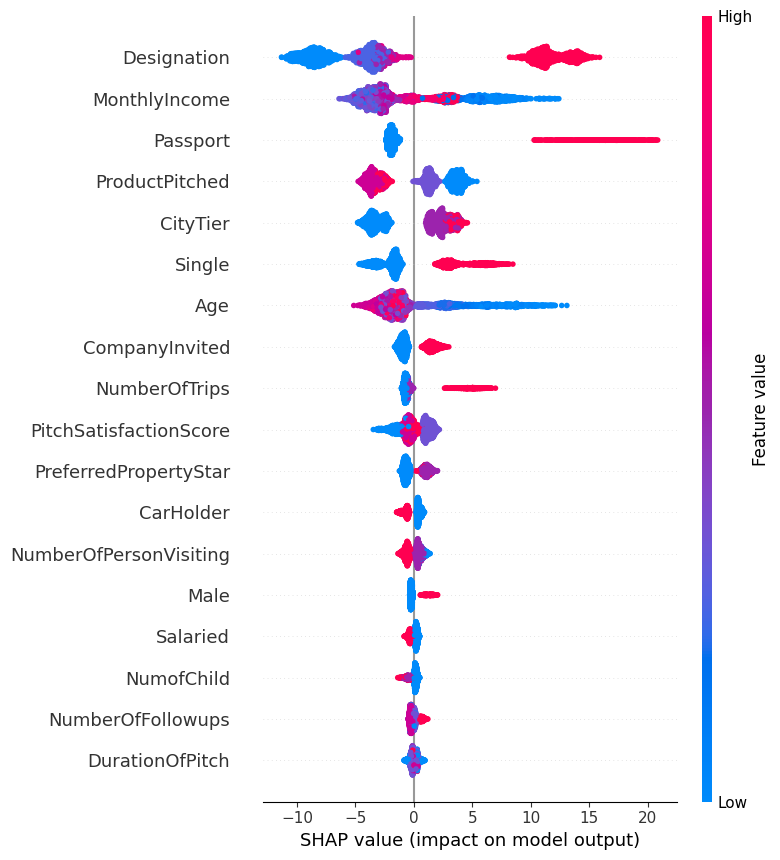

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
    shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1))

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

NameError: name 'oof_lgb' is not defined

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict = 0
for i in range(3):
  for j in range(5):
    predict = predict + models[i][j].predict(test)
predict = predict / 15
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.835515	valid's auc: 0.836304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846733	valid's auc: 0.840351
[300]	train's auc: 0.855644	valid's auc: 0.839666
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833964	valid's auc: 0.827559
[200]	train's auc: 0.845655	valid's auc: 0.837258
[300]	train's auc: 0.854293	valid's auc: 0.843077
[400]	train's auc: 0.86177	valid's auc: 0.843294
[500]	train's auc: 0.867884	valid's auc: 0.84495
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843199	valid's auc: 0.793562
[200]	train's auc: 0.853454	valid's auc: 0.802718
[300]	train's auc: 0.862205	valid's auc: 0.809329
[400]	train's auc: 0.868638	valid's auc: 0.80857
#########################
### Fold 4
#########################
[100]	train's auc: 0.837455	valid's auc: 0.824784
[200]	train's auc: 0.850055	valid's auc: 0.827878


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858332	valid's auc: 0.831824
[400]	train's auc: 0.865231	valid's auc: 0.83233
[500]	train's auc: 0.871703	valid's auc: 0.834354
#########################
### Fold 5
#########################
[100]	train's auc: 0.842865	valid's auc: 0.801544


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852312	valid's auc: 0.816206
[300]	train's auc: 0.86099	valid's auc: 0.821172
[400]	train's auc: 0.868284	valid's auc: 0.822523
[500]	train's auc: 0.873781	valid's auc: 0.823959
[600]	train's auc: 0.878005	valid's auc: 0.825344
CPU times: user 24.8 s, sys: 904 ms, total: 25.7 s
Wall time: 4.49 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8299435651341203
